In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


True

In [3]:
from collections import defaultdict
def double_conv3d(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv3d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    )   

def double_conv2d(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv2d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    ) 


class UNet2D3D(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.1):
        super().__init__()
#       3d conv          
        self.dconv_down13d = double_conv3d(in_channels, 32)
        self.dconv_down23d = double_conv3d(32, 64)
        self.dconv_down33d = double_conv3d(64, 128)
        self.dconv_down43d = double_conv3d(128, 256)
#         self.dconv_down5 = double_conv3d(128, 256)

        self.maxpool3d = nn.MaxPool3d(2)
        self.upsample3d = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)  
#         self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        
#         self.dconv_up4 = double_conv3d(128 + 256, 128)
        self.dconv_up33d = double_conv3d(128+ 256, 128)
        self.dconv_up23d = double_conv3d(64 + 128, 64)
        self.dconv_up13d = double_conv3d(32 + 64, 32)
        
        self.conv_last3d = nn.Conv3d(32, in_channels, 1)
        
        self.fc13d = nn.Linear(2048,1024)
        
#       2d conv
        self.dconv_down12d = double_conv2d(in_channels, 64)
        self.dconv_down22d = double_conv2d(64, 128)
        self.dconv_down32d = double_conv2d(128, 256)
        self.dconv_down42d = double_conv2d(256, 512)
        self.dconv_down52d = double_conv2d(512, 1024)

        self.maxpool2d = nn.MaxPool2d(2)
        self.upsample2d = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up42d = double_conv2d(512 + 1024, 512)
        self.dconv_up32d = double_conv2d(256 + 512, 256)
        self.dconv_up22d = double_conv2d(128 + 256, 128)
        self.dconv_up12d = double_conv2d(64 + 128, 64)
        
        self.conv_last2d = nn.Conv2d(64, in_channels, 1)
        
        self.fc12d = nn.Linear(25600,1024)
        
#       shared functions  
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(2048,2048)
        self.out = nn.Linear(2048, n_class)
        self.relu = nn.ReLU()
#         self.signmoid = nn.Sigmoid()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x2d, x3d):
#       3d contraction path  
        conv13d = self.dconv_down13d(x3d)
        x3d = self.maxpool3d(conv13d)

        conv23d = self.dconv_down23d(x3d)
        x3d = self.maxpool3d(conv23d)
        
        conv33d = self.dconv_down33d(x3d)
        x3d = self.maxpool3d(conv33d)   
        
        conv43d = self.dconv_down43d(x3d)
        
#       2d contraction path  
        conv12d = self.dconv_down12d(x2d)
        x2d = self.maxpool2d(conv12d)

        conv22d = self.dconv_down22d(x2d)
        x2d = self.maxpool2d(conv22d)
        
        conv32d = self.dconv_down32d(x2d)
        x2d = self.maxpool2d(conv32d)   
        
        conv42d = self.dconv_down42d(x2d)
        x2d = self.maxpool2d(conv42d) 
    
        x2d = self.dconv_down52d(x2d) 
        

        #Classifier
#       2d flatten
        flatten2d = x2d.view(x2d.size(0),-1)
        y2d = self.fc12d(flatten2d)
    
#       3d flatten
        x13d = self.maxpool3d(conv43d) 
#         print('x1:',x1.size())
        flatten3d = x13d.view(x13d.size(0),-1)
#         print('fc:',flatten.size())
        y3d = self.fc13d(flatten3d)
    
#       combine flatten features
        y = torch.cat([y2d, y3d], dim=1)
        y = self.relu(y)
        y= self.fc2(y)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)
        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
        
#         print('x: ',x.size())
# #         x = self.upsample(x)
#         print('x: ',x.size())
#         print('conv12d: ',conv12d.size())
#         print('conv22d: ',conv22d.size())
#         print('conv32d: ',conv32d.size())
#         print('conv42d: ',conv42d.size())
        
#         print('conv13d: ',conv13d.size())
#         print('conv23d: ',conv23d.size())
#         print('conv33d: ',conv33d.size())
#         print('conv43d: ',conv43d.size())
#         x = torch.cat([x, conv4], dim=1)
#         x = self.dconv_up4(x)
        
#       3d Upsampling path  
        x3d = self.upsample3d(conv43d)        
        x3d = torch.cat([x3d, conv33d], dim=1)
#         print('x: ',x.size())
        x3d = self.dconv_up33d(x3d)
        x3d = self.upsample3d(x3d)
        
        x3d = torch.cat([x3d, conv23d], dim=1)       

        x3d = self.dconv_up23d(x3d)
        x3d = self.upsample3d(x3d)        
        x3d = torch.cat([x3d, conv13d], dim=1)   
        
        x3d = self.dconv_up13d(x3d)
        
        x3d = self.conv_last3d(x3d)
        out3d = x3d
#         out3d = self.relu(x3d)
        
#       2d Upsampling path
#         print('x2d: ', x2d.size())
        x2d = self.upsample2d(x2d)
#         print('x2d: ', x2d.size())
        x2d = torch.cat([x2d, conv42d], dim=1)
        x2d = self.dconv_up42d(x2d)
#         print('x2d: ', x2d.size())
        
        x2d = self.upsample2d(x2d)        
        x2d = torch.cat([x2d, conv32d], dim=1)
        
        x2d = self.dconv_up32d(x2d)
        x2d = self.upsample2d(x2d)
        
        x2d = torch.cat([x2d, conv22d], dim=1)       

        x2d = self.dconv_up22d(x2d)
        x2d = self.upsample2d(x2d)
#         print('x2d: ', x2d.size())
        x2d = torch.cat([x2d, conv12d], dim=1)   
#         print('x2d: ', x2d.size())
        x2d = self.dconv_up12d(x2d)
#         print('x2d: ', x2d.size())
        out2d = self.conv_last2d(x2d)
#         out2d = self.relu(out2d)
        return out2d,out3d,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.Conv3d:
        m.weight.data.normal_(0, 0.0001)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
# from torchsummary import summary

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UNet2D3D(3,1)
# model.apply (init_weights)
# model = model.to(device)
# # model
# summary(model, [(1, 80, 80),(1, 40, 40, 40)])

In [6]:
from collections import defaultdict
import torch.nn.functional as F
import tqdm

In [7]:
def calc_loss(out2d, out3d, prediction, target, original2d, original3d,metrics, MSE_weight=0.5):
#     print(prediction)
#     print(target)
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
    out2d = torch.sigmoid(out2d)
    out3d = torch.sigmoid(out3d)
    MSE2d = F.mse_loss(out2d, original2d)
    MSE3d = F.mse_loss(out3d, original3d)
    MSE = 0.5*MSE2d+0.5*MSE3d
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
#     print('CE', metrics['CE'])
#     print('MSE', metrics['MSE'])
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [8]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    outer = tqdm.tqdm(total=num_epochs, desc='num_epochs', position=0)
    
    for epoch in range(num_epochs):
        print('\n')
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
#             LabelList = torch.tensor([1]).to(device)
#             PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(2, 2)
            for inputs2d, inputs3d, labels in dataloaders[phase]:
#                 inputs2d = inputs2d.to(device).half()
#                 inputs3d = inputs3d.to(device).half()
                inputs2d = inputs2d.to(device)
                inputs3d = inputs3d.to(device)
                labels = labels.to(device)            

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs2d, outputs3d, predictions = model(inputs2d,inputs3d)
                    loss = calc_loss(outputs2d, outputs3d, predictions,labels,inputs2d,inputs3d, metrics,MSE_weight = 0.1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
#                         nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
                        nn.utils.clip_grad_value_(model.parameters(),clip_value=0.5)
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                
                # statistics
                epoch_samples += inputs2d.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T
            print(confusionMat)
            summat = np.tile(sumconfusion,(2,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/2
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                else:
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 1 and val_MSEloss_history[-1] > 7e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        outer.update(1)
        
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [9]:
Datadir = "H:\\LIverCellData\\Stellates\\ImagesForTraining"

In [10]:
import os

def datapreparation(Datadir):
    trainpath2d = []
    trainpath3d = []
    trainlabel = []
    trainsubjectlabel = []
    fpath = []
    
    traindir = Datadir + "\\SC38\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC38 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(0)
        trainsubjectlabel.append(0)
        
    fpath = []    
    traindir = Datadir + "\\SC38\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC38 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\SC67\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC67 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(0)
        trainsubjectlabel.append(1)
        
    fpath = []    
    traindir = Datadir + "\\SC67\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC67 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\SC46\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC46 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(1)
        trainsubjectlabel.append(2)
        
    fpath = []    
    traindir = Datadir + "\\SC46\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC46 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\SC74\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC46 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(1)
        trainsubjectlabel.append(3)
        
    fpath = []    
    traindir = Datadir + "\\SC74\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SC74 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
        
    return trainpath2d,trainpath3d, trainlabel, trainsubjectlabel

In [11]:
X2d,X3d, Y,Y1 = datapreparation(Datadir)
print(len(X2d))
print(len(X3d))
print(len(Y))
print([Y1[15001]])

SC38 2D data: 5000
SC38 3D data: 5000
SC67 2D data: 5000
SC67 3D data: 5000
SC46 2D data: 5000
SC46 3D data: 5000
SC46 2D data: 5000
SC74 3D data: 5000
20000
20000
20000
[3]


In [12]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4,shuffle=False)
trainindex2d = {}
testindex2d = {}
trainindex3d = {}
testindex3d = {}
i = 0
for train_index2d, test_index2d in kfold.split(X2d,Y1):
    print("Train Index: ", train_index2d)
    print("Test Index: ", test_index2d, "\n")
    trainindex2d[i] = train_index2d
    testindex2d[i] = test_index2d
    i = i + 1
    
i = 0
for train_index3d, test_index3d in kfold.split(X3d,Y1):
    print("Train Index: ", train_index3d)
    print("Test Index: ", test_index3d, "\n")
    trainindex3d[i] = train_index3d
    testindex3d[i] = test_index3d
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath2d =[X2d[i] for i in trainindex2d[0]]
trainpath3d =[X3d[i] for i in trainindex3d[0]]
Y_kfold = [Y[i] for i in trainindex2d[0]]
print(sum(Y_kfold))
testpath2d =[X2d[i] for i in testindex2d[0]]
testpath3d =[X3d[i] for i in testindex3d[0]]

Train Index:  [ 1250  1251  1252 ... 19997 19998 19999]
Test Index:  [    0     1     2 ... 16247 16248 16249] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 1250  1251  1252 ... 17497 17498 17499] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 2500  2501  2502 ... 18747 18748 18749] 

Train Index:  [    0     1     2 ... 18747 18748 18749]
Test Index:  [ 3750  3751  3752 ... 19997 19998 19999] 

Train Index:  [ 1250  1251  1252 ... 19997 19998 19999]
Test Index:  [    0     1     2 ... 16247 16248 16249] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 1250  1251  1252 ... 17497 17498 17499] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 2500  2501  2502 ... 18747 18748 18749] 

Train Index:  [    0     1     2 ... 18747 18748 18749]
Test Index:  [ 3750  3751  3752 ... 19997 19998 19999] 

7500


In [13]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths2d, mat_paths3d,transforms=None):
        self.paths2d = mat_paths2d
        self.paths3d = mat_paths3d
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data2d = io.imread(self.paths2d[index])
        data3d = io.imread(self.paths3d[index])
        
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x2d = torch.from_numpy(data2d.astype(np.float32)/65535)
        x3d = torch.from_numpy(data3d.astype(np.float32)/65535)
        x2d = x2d.unsqueeze(dim = 0)
        
#         x = x.unsqueeze(dim = 0)
        x3d = np.transpose(x3d,(2,0,1))
        x3d = x3d.unsqueeze(dim = 0)
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'SC38' in self.paths2d[index]:
            label = int(0)
        elif 'SC67' in self.paths2d[index]:
            label = int(0)
        elif 'SC46' in self.paths2d[index]:
            label = int(1)
        elif 'SC74' in self.paths2d[index]:
            label = int(1)
        
        if self.transforms:
            x2d= self.transforms(x2d)
            x3d= self.transforms(x3d)
            
        return x2d,x3d,label
    
    def __len__(self):
        return len(self.paths2d)
    
    def __subitem__(self, index):
        if 'SC38' in self.paths2d[index]:
            slabel = int(0)
        elif 'SC67' in self.paths2d[index]:
            slabel = int(1)
        elif 'SC46' in self.paths2d[index]:
            slabel = int(2)
        elif 'SC74' in self.paths2d[index]:
            slabel = int(3)     
        return slabel

In [14]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath2d,trainpath3d)
image_datasets['val'] = MyDataset(testpath2d,testpath3d)

# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Healthy','Diseased']
SubName = ['SC38','SC67','SC46','SC74']
[ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(2)
print('Type label: ',CellName[ImgLabel])
print('Subject label: ',SubName[image_datasets['train'].__subitem__(2)])
print('2d image tensor shape: ', ImgTensor2d.shape)
print('2d image tensor dtype: ', ImgTensor2d.dtype)
print('3d image tensor shape: ', ImgTensor3d.shape)
print('3d image tensor dtype: ', ImgTensor3d.dtype)


#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor3d.numpy())
print('image shape: ', image.shape)

training data volume:  15000
validation data volume:  5000
Type label:  Healthy
Subject label:  SC38
2d image tensor shape:  torch.Size([1, 80, 80])
2d image tensor dtype:  torch.float32
3d image tensor shape:  torch.Size([1, 40, 40, 40])
3d image tensor dtype:  torch.float32
image shape:  (40, 40, 40)


In [15]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,ImgIdx):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*4],vmin=LimMin, vmax=LimMax, cmap ='jet')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*4],vmin=LimMin, vmax=LimMax, cmap ='jet')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection, Index: %i'%ImgIdx)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()



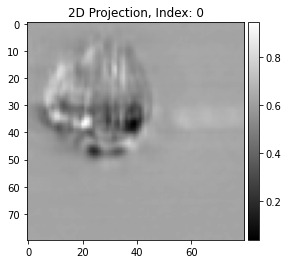

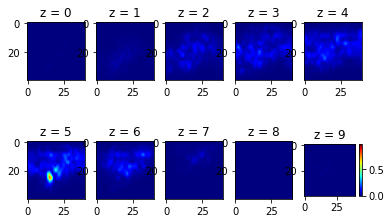

In [16]:
ImgIdx = 0
[ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(ImgIdx)
image2d = np.transpose(ImgTensor2d.numpy(), (1,2,0))
image3d = np.transpose(np.squeeze(ImgTensor3d.numpy()), (1,2,0))
DisplayImage(image2d,image2d.min(),image2d.max(),ImgIdx)
DisplayImage(image3d,image3d.min(),image3d.max(),ImgIdx)

In [17]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}
# dataloaders_dict = {}
# dataloaders_dict ['train'] = torch.utils.data.DataLoader(image_datasets['train'],batch_size=batch_size, num_workers=0, sampler=weighted_sampler)
# dataloaders_dict ['val'] = torch.utils.data.DataLoader(image_datasets['val'],batch_size=batch_size, shuffle=True, num_workers=0)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                               | 0/50 [00:00<?, ?it/s]



----------
Epoch 0/49
LR 1e-05
[[5928. 1572.]
 [3621. 3879.]]
train: CE: 0.613482, MSE: 0.142190, loss: 0.566353
train Acc: 0.6538
train Bal. Acc: 0.6538


num_epochs:   2%|█▎                                                                  | 1/50 [06:45<5:31:26, 405.84s/it]

[[  24. 2476.]
 [   0. 2500.]]
val: CE: 1.006192, MSE: 0.131869, loss: 0.918759
val Acc: 0.5048
val Bal. Acc: 0.5048
saving best model
Total time: 0:06:45.856668
Epoch time: 6m 46s


----------
Epoch 1/49
LR 1e-05
[[6378. 1122.]
 [1232. 6268.]]
train: CE: 0.352585, MSE: 0.060051, loss: 0.323332
train Acc: 0.8431
train Bal. Acc: 0.8431


num_epochs:   4%|██▋                                                                 | 2/50 [13:18<5:18:21, 397.94s/it]

[[2.510e+02 2.249e+03]
 [1.000e+00 2.499e+03]]
val: CE: 1.386288, MSE: 0.009314, loss: 1.248590
val Acc: 0.5500
val Bal. Acc: 0.5500
saving best model
Total time: 0:13:18.273982
Epoch time: 6m 32s


----------
Epoch 2/49
LR 1e-05
[[6674.  826.]
 [ 483. 7017.]]
train: CE: 0.221533, MSE: 0.007605, loss: 0.200140
train Acc: 0.9127
train Bal. Acc: 0.9127


num_epochs:   6%|████                                                                | 3/50 [19:47<5:08:44, 394.13s/it]

[[2304.  196.]
 [ 183. 2317.]]
val: CE: 0.213204, MSE: 0.006981, loss: 0.192582
val Acc: 0.9242
val Bal. Acc: 0.9242
saving best model
Total time: 0:19:47.866619
Epoch time: 6m 30s


----------
Epoch 3/49
LR 1e-05
[[6957.  543.]
 [ 240. 7260.]]
train: CE: 0.142476, MSE: 0.005423, loss: 0.128771
train Acc: 0.9478
train Bal. Acc: 0.9478


num_epochs:   8%|█████▍                                                              | 4/50 [26:18<5:01:02, 392.66s/it]

[[2150.  350.]
 [  46. 2454.]]
val: CE: 0.204046, MSE: 0.004191, loss: 0.184060
val Acc: 0.9208
val Bal. Acc: 0.9208
Total time: 0:26:18.267042
Epoch time: 6m 30s


----------
Epoch 4/49
LR 1e-05
[[7104.  396.]
 [ 181. 7319.]]
train: CE: 0.107931, MSE: 0.003924, loss: 0.097530
train Acc: 0.9615
train Bal. Acc: 0.9615


num_epochs:  10%|██████▊                                                             | 5/50 [32:48<4:53:42, 391.61s/it]

[[2306.  194.]
 [  59. 2441.]]
val: CE: 0.145256, MSE: 0.003488, loss: 0.131079
val Acc: 0.9494
val Bal. Acc: 0.9494
saving best model
Total time: 0:32:48.019915
Epoch time: 6m 30s


----------
Epoch 5/49
LR 5e-05
[[6984.  516.]
 [ 253. 7247.]]
train: CE: 0.130469, MSE: 0.003504, loss: 0.117773
train Acc: 0.9487
train Bal. Acc: 0.9487


num_epochs:  12%|████████▏                                                           | 6/50 [39:16<4:46:28, 390.66s/it]

[[ 747. 1753.]
 [   0. 2500.]]
val: CE: 1.220044, MSE: 0.002898, loss: 1.098330
val Acc: 0.6494
val Bal. Acc: 0.6494
Total time: 0:39:16.828545
Epoch time: 6m 29s


----------
Epoch 6/49
LR 5e-05
[[7172.  328.]
 [ 151. 7349.]]
train: CE: 0.088702, MSE: 0.002468, loss: 0.080078
train Acc: 0.9681
train Bal. Acc: 0.9681


num_epochs:  14%|█████████▌                                                          | 7/50 [45:44<4:39:12, 389.59s/it]

[[2486.   14.]
 [1588.  912.]]
val: CE: 1.633686, MSE: 0.002041, loss: 1.470522
val Acc: 0.6796
val Bal. Acc: 0.6796
Total time: 0:45:44.233156
Epoch time: 6m 27s


----------
Epoch 7/49
LR 5e-05
[[7188.  312.]
 [ 129. 7371.]]
train: CE: 0.074628, MSE: 0.002051, loss: 0.067370
train Acc: 0.9706
train Bal. Acc: 0.9706


num_epochs:  16%|██████████▉                                                         | 8/50 [52:11<4:32:15, 388.93s/it]

[[1801.  699.]
 [   0. 2500.]]
val: CE: 0.451337, MSE: 0.001775, loss: 0.406381
val Acc: 0.8602
val Bal. Acc: 0.8602
Total time: 0:52:11.755586
Epoch time: 6m 28s


----------
Epoch 8/49
LR 5e-05
[[7264.  236.]
 [ 101. 7399.]]
train: CE: 0.062189, MSE: 0.001793, loss: 0.056149
train Acc: 0.9775
train Bal. Acc: 0.9775


num_epochs:  18%|████████████▏                                                       | 9/50 [58:41<4:25:57, 389.21s/it]

[[2482.   18.]
 [ 765. 1735.]]
val: CE: 0.417523, MSE: 0.001746, loss: 0.375945
val Acc: 0.8434
val Bal. Acc: 0.8434
Total time: 0:58:41.574117
Epoch time: 6m 30s


----------
Epoch 9/49
LR 5e-05
[[7343.  157.]
 [  84. 7416.]]
train: CE: 0.044318, MSE: 0.001385, loss: 0.040025
train Acc: 0.9839
train Bal. Acc: 0.9839


num_epochs:  20%|█████████████                                                    | 10/50 [1:05:09<4:19:07, 388.68s/it]

[[2496.    4.]
 [1973.  527.]]
val: CE: 2.833372, MSE: 0.001331, loss: 2.550167
val Acc: 0.6046
val Bal. Acc: 0.6046
Total time: 1:05:09.070019
Epoch time: 6m 27s


----------
Epoch 10/49
LR 5e-05
[[7311.  189.]
 [  88. 7412.]]
train: CE: 0.048736, MSE: 0.001301, loss: 0.043993
train Acc: 0.9815
train Bal. Acc: 0.9815


num_epochs:  22%|██████████████▎                                                  | 11/50 [1:11:35<4:12:16, 388.11s/it]

[[2042.  458.]
 [   5. 2495.]]
val: CE: 0.280859, MSE: 0.001300, loss: 0.252903
val Acc: 0.9074
val Bal. Acc: 0.9074
Total time: 1:11:35.873576
Epoch time: 6m 27s


----------
Epoch 11/49
LR 5e-05
[[7325.  175.]
 [  75. 7425.]]
train: CE: 0.040999, MSE: 0.001187, loss: 0.037018
train Acc: 0.9833
train Bal. Acc: 0.9833


num_epochs:  24%|███████████████▌                                                 | 12/50 [1:18:01<4:05:24, 387.48s/it]

[[2372.  128.]
 [  43. 2457.]]
val: CE: 0.112106, MSE: 0.001303, loss: 0.101025
val Acc: 0.9658
val Bal. Acc: 0.9658
saving best model
Total time: 1:18:01.926729
Epoch time: 6m 26s


----------
Epoch 12/49
LR 5e-05
[[7402.   98.]
 [  78. 7422.]]
train: CE: 0.032035, MSE: 0.001198, loss: 0.028951
train Acc: 0.9883
train Bal. Acc: 0.9883


num_epochs:  26%|████████████████▉                                                | 13/50 [1:24:28<3:58:51, 387.34s/it]

[[2441.   59.]
 [ 163. 2337.]]
val: CE: 0.143291, MSE: 0.001178, loss: 0.129080
val Acc: 0.9556
val Bal. Acc: 0.9556
Total time: 1:24:28.933574
Epoch time: 6m 27s


----------
Epoch 13/49
LR 5e-05
[[7399.  101.]
 [  46. 7454.]]
train: CE: 0.026440, MSE: 0.001142, loss: 0.023910
train Acc: 0.9902
train Bal. Acc: 0.9902


num_epochs:  28%|██████████████████▏                                              | 14/50 [1:30:55<3:52:16, 387.14s/it]

[[2389.  111.]
 [ 112. 2388.]]
val: CE: 0.169931, MSE: 0.001152, loss: 0.153053
val Acc: 0.9554
val Bal. Acc: 0.9554
Total time: 1:30:55.600812
Epoch time: 6m 27s


----------
Epoch 14/49
LR 5e-05
[[7382.  118.]
 [  61. 7439.]]
train: CE: 0.032940, MSE: 0.001056, loss: 0.029751
train Acc: 0.9881
train Bal. Acc: 0.9881


num_epochs:  30%|███████████████████▌                                             | 15/50 [1:37:22<3:45:44, 387.00s/it]

[[2255.  245.]
 [  27. 2473.]]
val: CE: 0.164092, MSE: 0.001127, loss: 0.147795
val Acc: 0.9456
val Bal. Acc: 0.9456
Total time: 1:37:22.278950
Epoch time: 6m 27s


----------
Epoch 15/49
LR 5e-05
[[7430.   70.]
 [  43. 7457.]]
train: CE: 0.022300, MSE: 0.001044, loss: 0.020174
train Acc: 0.9925
train Bal. Acc: 0.9925


num_epochs:  32%|████████████████████▊                                            | 16/50 [1:43:48<3:39:09, 386.74s/it]

[[1635.  865.]
 [   0. 2500.]]
val: CE: 0.629529, MSE: 0.001077, loss: 0.566683
val Acc: 0.8270
val Bal. Acc: 0.8270
Total time: 1:43:48.407773
Epoch time: 6m 26s


----------
Epoch 16/49
LR 5e-05
[[7425.   75.]
 [  45. 7455.]]
train: CE: 0.020150, MSE: 0.001010, loss: 0.018236
train Acc: 0.9920
train Bal. Acc: 0.9920


num_epochs:  34%|██████████████████████                                           | 17/50 [1:50:14<3:32:34, 386.51s/it]

[[2456.   44.]
 [ 157. 2343.]]
val: CE: 0.150285, MSE: 0.001073, loss: 0.135364
val Acc: 0.9598
val Bal. Acc: 0.9598
Epoch    12: reducing learning rate of group 0 to 2.5000e-05.
Total time: 1:50:14.390564
Epoch time: 6m 26s


----------
Epoch 17/49
LR 2.5e-05
[[7466.   34.]
 [  19. 7481.]]
train: CE: 0.010164, MSE: 0.000983, loss: 0.009246
train Acc: 0.9965
train Bal. Acc: 0.9965


num_epochs:  36%|███████████████████████▍                                         | 18/50 [1:56:41<3:26:11, 386.61s/it]

[[2338.  162.]
 [  30. 2470.]]
val: CE: 0.140702, MSE: 0.001036, loss: 0.126736
val Acc: 0.9616
val Bal. Acc: 0.9616
Total time: 1:56:41.242297
Epoch time: 6m 27s


----------
Epoch 18/49
LR 2.5e-05
[[7482.   18.]
 [  12. 7488.]]
train: CE: 0.006243, MSE: 0.000968, loss: 0.005716
train Acc: 0.9980
train Bal. Acc: 0.9980


num_epochs:  38%|████████████████████████▋                                        | 19/50 [2:03:07<3:19:38, 386.41s/it]

[[2368.  132.]
 [  35. 2465.]]
val: CE: 0.130908, MSE: 0.001024, loss: 0.117920
val Acc: 0.9666
val Bal. Acc: 0.9666
saving best model
Total time: 2:03:07.182088
Epoch time: 6m 26s


----------
Epoch 19/49
LR 2.5e-05
[[7482.   18.]
 [  11. 7489.]]
train: CE: 0.005250, MSE: 0.000958, loss: 0.004821
train Acc: 0.9981
train Bal. Acc: 0.9981


num_epochs:  40%|██████████████████████████                                       | 20/50 [2:09:33<3:13:13, 386.43s/it]

[[2217.  283.]
 [   5. 2495.]]
val: CE: 0.230811, MSE: 0.001011, loss: 0.207831
val Acc: 0.9424
val Bal. Acc: 0.9424
Total time: 2:09:33.672229
Epoch time: 6m 26s


----------
Epoch 20/49
LR 2.5e-05
[[7.494e+03 6.000e+00]
 [7.000e+00 7.493e+03]]
train: CE: 0.002911, MSE: 0.000945, loss: 0.002715
train Acc: 0.9991
train Bal. Acc: 0.9991


num_epochs:  42%|███████████████████████████▎                                     | 21/50 [2:16:00<3:06:46, 386.43s/it]

[[2402.   98.]
 [  68. 2432.]]
val: CE: 0.129047, MSE: 0.001001, loss: 0.116243
val Acc: 0.9668
val Bal. Acc: 0.9668
saving best model
Total time: 2:16:00.081262
Epoch time: 6m 26s


----------
Epoch 21/49
LR 2.5e-05
[[7.487e+03 1.300e+01]
 [5.000e+00 7.495e+03]]
train: CE: 0.003544, MSE: 0.000938, loss: 0.003283
train Acc: 0.9988
train Bal. Acc: 0.9988


num_epochs:  44%|████████████████████████████▌                                    | 22/50 [2:22:26<3:00:17, 386.33s/it]

[[2402.   98.]
 [  43. 2457.]]
val: CE: 0.114954, MSE: 0.000996, loss: 0.103558
val Acc: 0.9718
val Bal. Acc: 0.9718
saving best model
Total time: 2:22:26.183619
Epoch time: 6m 26s


----------
Epoch 22/49
LR 2.5e-05
[[7485.   15.]
 [  12. 7488.]]
train: CE: 0.005525, MSE: 0.000928, loss: 0.005065
train Acc: 0.9982
train Bal. Acc: 0.9982


num_epochs:  46%|█████████████████████████████▉                                   | 23/50 [2:28:52<2:53:50, 386.33s/it]

[[2384.  116.]
 [  44. 2456.]]
val: CE: 0.132419, MSE: 0.000984, loss: 0.119276
val Acc: 0.9680
val Bal. Acc: 0.9680
Total time: 2:28:52.521708
Epoch time: 6m 26s


----------
Epoch 23/49
LR 2.5e-05
[[7.496e+03 4.000e+00]
 [8.000e+00 7.492e+03]]
train: CE: 0.003381, MSE: 0.000920, loss: 0.003135
train Acc: 0.9992
train Bal. Acc: 0.9992


num_epochs:  48%|███████████████████████████████▏                                 | 24/50 [2:35:19<2:47:28, 386.47s/it]

[[2380.  120.]
 [  36. 2464.]]
val: CE: 0.130928, MSE: 0.000979, loss: 0.117933
val Acc: 0.9688
val Bal. Acc: 0.9688
Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Total time: 2:35:19.325083
Epoch time: 6m 27s


----------
Epoch 24/49
LR 1.25e-05
[[7.493e+03 7.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001953, MSE: 0.000912, loss: 0.001848
train Acc: 0.9994
train Bal. Acc: 0.9994


num_epochs:  50%|████████████████████████████████▌                                | 25/50 [2:41:45<2:41:00, 386.41s/it]

[[2421.   79.]
 [  56. 2444.]]
val: CE: 0.117400, MSE: 0.000970, loss: 0.105757
val Acc: 0.9730
val Bal. Acc: 0.9730
saving best model
Total time: 2:41:45.596978
Epoch time: 6m 26s


----------
Epoch 25/49
LR 1.25e-05
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000763, MSE: 0.000907, loss: 0.000778
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  52%|█████████████████████████████████▊                               | 26/50 [2:48:11<2:34:30, 386.25s/it]

[[2375.  125.]
 [  31. 2469.]]
val: CE: 0.127651, MSE: 0.000966, loss: 0.114982
val Acc: 0.9688
val Bal. Acc: 0.9688
Total time: 2:48:11.477157
Epoch time: 6m 26s


----------
Epoch 26/49
LR 1.25e-05
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000674, MSE: 0.000903, loss: 0.000697
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  54%|███████████████████████████████████                              | 27/50 [2:54:37<2:27:59, 386.08s/it]

[[2379.  121.]
 [  29. 2471.]]
val: CE: 0.130222, MSE: 0.000962, loss: 0.117296
val Acc: 0.9700
val Bal. Acc: 0.9700
Total time: 2:54:37.159458
Epoch time: 6m 26s


----------
Epoch 27/49
LR 1.25e-05
[[7.499e+03 1.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000905, MSE: 0.000899, loss: 0.000904
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  56%|████████████████████████████████████▍                            | 28/50 [3:01:02<2:21:29, 385.88s/it]

[[2381.  119.]
 [  30. 2470.]]
val: CE: 0.143948, MSE: 0.000958, loss: 0.129649
val Acc: 0.9702
val Bal. Acc: 0.9702
Total time: 3:01:02.552754
Epoch time: 6m 25s


----------
Epoch 28/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000811, MSE: 0.000895, loss: 0.000820
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  58%|█████████████████████████████████████▋                           | 29/50 [3:07:28<2:15:01, 385.79s/it]

[[2362.  138.]
 [  26. 2474.]]
val: CE: 0.140671, MSE: 0.000954, loss: 0.126699
val Acc: 0.9672
val Bal. Acc: 0.9672
Total time: 3:07:28.151847
Epoch time: 6m 26s


----------
Epoch 29/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000679, MSE: 0.000892, loss: 0.000700
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  60%|███████████████████████████████████████                          | 30/50 [3:13:53<2:08:33, 385.66s/it]

[[2342.  158.]
 [  18. 2482.]]
val: CE: 0.163089, MSE: 0.000950, loss: 0.146875
val Acc: 0.9648
val Bal. Acc: 0.9648
Total time: 3:13:53.488892
Epoch time: 6m 25s


----------
Epoch 30/49
LR 1.25e-05
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000514, MSE: 0.000888, loss: 0.000551
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  62%|████████████████████████████████████████▎                        | 31/50 [3:20:19<2:02:08, 385.72s/it]

[[2412.   88.]
 [  47. 2453.]]
val: CE: 0.124339, MSE: 0.000947, loss: 0.111999
val Acc: 0.9730
val Bal. Acc: 0.9730
Epoch    26: reducing learning rate of group 0 to 6.2500e-06.
Total time: 3:20:19.358470
Epoch time: 6m 26s


----------
Epoch 31/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000299, MSE: 0.000886, loss: 0.000357
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  64%|█████████████████████████████████████████▌                       | 32/50 [3:26:45<1:55:44, 385.80s/it]

[[2398.  102.]
 [  41. 2459.]]
val: CE: 0.125150, MSE: 0.000945, loss: 0.112730
val Acc: 0.9714
val Bal. Acc: 0.9714
Total time: 3:26:45.351149
Epoch time: 6m 26s


----------
Epoch 32/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000439, MSE: 0.000884, loss: 0.000484
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  66%|██████████████████████████████████████████▉                      | 33/50 [3:33:11<1:49:20, 385.93s/it]

[[2358.  142.]
 [  20. 2480.]]
val: CE: 0.148418, MSE: 0.000943, loss: 0.133671
val Acc: 0.9676
val Bal. Acc: 0.9676
Total time: 3:33:11.571689
Epoch time: 6m 26s


----------
Epoch 33/49
LR 6.25e-06
[[7.496e+03 4.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000786, MSE: 0.000882, loss: 0.000796
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  68%|████████████████████████████████████████████▏                    | 34/50 [3:39:37<1:42:55, 385.99s/it]

[[2382.  118.]
 [  27. 2473.]]
val: CE: 0.139678, MSE: 0.000941, loss: 0.125804
val Acc: 0.9710
val Bal. Acc: 0.9710
Total time: 3:39:37.705791
Epoch time: 6m 26s


----------
Epoch 34/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000375, MSE: 0.000880, loss: 0.000426
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  70%|█████████████████████████████████████████████▌                   | 35/50 [3:46:03<1:36:28, 385.88s/it]

[[2366.  134.]
 [  19. 2481.]]
val: CE: 0.144041, MSE: 0.000939, loss: 0.129731
val Acc: 0.9694
val Bal. Acc: 0.9694
Total time: 3:46:03.330212
Epoch time: 6m 26s


----------
Epoch 35/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000415, MSE: 0.000879, loss: 0.000462
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  72%|██████████████████████████████████████████████▊                  | 36/50 [3:52:28<1:29:59, 385.65s/it]

[[2372.  128.]
 [  24. 2476.]]
val: CE: 0.140503, MSE: 0.000938, loss: 0.126547
val Acc: 0.9696
val Bal. Acc: 0.9696
Total time: 3:52:28.431800
Epoch time: 6m 25s


----------
Epoch 36/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000319, MSE: 0.000877, loss: 0.000375
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  74%|████████████████████████████████████████████████                 | 37/50 [3:58:54<1:23:34, 385.69s/it]

[[2376.  124.]
 [  27. 2473.]]
val: CE: 0.138182, MSE: 0.000936, loss: 0.124458
val Acc: 0.9698
val Bal. Acc: 0.9698
Total time: 3:58:54.236668
Epoch time: 6m 26s


----------
Epoch 37/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000304, MSE: 0.000875, loss: 0.000361
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  76%|█████████████████████████████████████████████████▍               | 38/50 [4:05:19<1:17:08, 385.70s/it]

[[2355.  145.]
 [  19. 2481.]]
val: CE: 0.159467, MSE: 0.000934, loss: 0.143614
val Acc: 0.9672
val Bal. Acc: 0.9672
Epoch    33: reducing learning rate of group 0 to 3.1250e-06.
Total time: 4:05:19.949508
Epoch time: 6m 26s


----------
Epoch 38/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000274, MSE: 0.000874, loss: 0.000334
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  78%|██████████████████████████████████████████████████▋              | 39/50 [4:11:45<1:10:41, 385.63s/it]

[[2400.  100.]
 [  41. 2459.]]
val: CE: 0.131010, MSE: 0.000933, loss: 0.118003
val Acc: 0.9718
val Bal. Acc: 0.9718
Total time: 4:11:45.419594
Epoch time: 6m 25s


----------
Epoch 39/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000264, MSE: 0.000873, loss: 0.000325
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  80%|████████████████████████████████████████████████████             | 40/50 [4:18:10<1:04:15, 385.59s/it]

[[2392.  108.]
 [  34. 2466.]]
val: CE: 0.131816, MSE: 0.000932, loss: 0.118728
val Acc: 0.9716
val Bal. Acc: 0.9716
Total time: 4:18:10.899045
Epoch time: 6m 25s


----------
Epoch 40/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000301, MSE: 0.000872, loss: 0.000359
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  82%|██████████████████████████████████████████████████████▉            | 41/50 [4:24:36<57:50, 385.61s/it]

[[2424.   76.]
 [  49. 2451.]]
val: CE: 0.119856, MSE: 0.000931, loss: 0.107963
val Acc: 0.9750
val Bal. Acc: 0.9750
saving best model
Total time: 4:24:36.553500
Epoch time: 6m 26s


----------
Epoch 41/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000254, MSE: 0.000871, loss: 0.000316
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  84%|████████████████████████████████████████████████████████▎          | 42/50 [4:31:02<51:25, 385.68s/it]

[[2394.  106.]
 [  35. 2465.]]
val: CE: 0.127212, MSE: 0.000930, loss: 0.114584
val Acc: 0.9718
val Bal. Acc: 0.9718
Total time: 4:31:02.397175
Epoch time: 6m 26s


----------
Epoch 42/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000662, MSE: 0.000870, loss: 0.000682
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  86%|█████████████████████████████████████████████████████████▌         | 43/50 [4:37:28<45:01, 385.91s/it]

[[2418.   82.]
 [  48. 2452.]]
val: CE: 0.121054, MSE: 0.000929, loss: 0.109042
val Acc: 0.9740
val Bal. Acc: 0.9740
Total time: 4:37:28.846295
Epoch time: 6m 26s


----------
Epoch 43/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000219, MSE: 0.000869, loss: 0.000284
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  88%|██████████████████████████████████████████████████████████▉        | 44/50 [4:43:55<38:36, 386.02s/it]

[[2412.   88.]
 [  48. 2452.]]
val: CE: 0.122131, MSE: 0.000929, loss: 0.110010
val Acc: 0.9728
val Bal. Acc: 0.9728
Total time: 4:43:55.129855
Epoch time: 6m 26s


----------
Epoch 44/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000247, MSE: 0.000869, loss: 0.000309
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  90%|████████████████████████████████████████████████████████████▎      | 45/50 [4:50:20<32:09, 385.97s/it]

[[2382.  118.]
 [  26. 2474.]]
val: CE: 0.137051, MSE: 0.000928, loss: 0.123439
val Acc: 0.9712
val Bal. Acc: 0.9712
Epoch    40: reducing learning rate of group 0 to 1.5625e-06.
Total time: 4:50:20.969742
Epoch time: 6m 26s


----------
Epoch 45/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000335, MSE: 0.000868, loss: 0.000388
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [4:56:46<25:43, 385.83s/it]

[[2374.  126.]
 [  25. 2475.]]
val: CE: 0.144880, MSE: 0.000927, loss: 0.130484
val Acc: 0.9698
val Bal. Acc: 0.9698
Total time: 4:56:46.469405
Epoch time: 6m 25s


----------
Epoch 46/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000448, MSE: 0.000867, loss: 0.000490
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [5:03:12<19:17, 385.79s/it]

[[2398.  102.]
 [  39. 2461.]]
val: CE: 0.127468, MSE: 0.000927, loss: 0.114814
val Acc: 0.9718
val Bal. Acc: 0.9718
Total time: 5:03:12.176739
Epoch time: 6m 26s


----------
Epoch 47/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000257, MSE: 0.000867, loss: 0.000318
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [5:09:37<12:51, 385.78s/it]

[[2396.  104.]
 [  39. 2461.]]
val: CE: 0.127818, MSE: 0.000926, loss: 0.115129
val Acc: 0.9714
val Bal. Acc: 0.9714
Total time: 5:09:37.931696
Epoch time: 6m 26s


----------
Epoch 48/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000432, MSE: 0.000866, loss: 0.000475
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [5:16:03<06:25, 385.64s/it]

[[2379.  121.]
 [  26. 2474.]]
val: CE: 0.141040, MSE: 0.000926, loss: 0.127028
val Acc: 0.9706
val Bal. Acc: 0.9706
Total time: 5:16:03.238149
Epoch time: 6m 25s


----------
Epoch 49/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000377, MSE: 0.000866, loss: 0.000426
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs: 100%|███████████████████████████████████████████████████████████████████| 50/50 [5:22:29<00:00, 386.98s/it]

[[2384.  116.]
 [  27. 2473.]]
val: CE: 0.135666, MSE: 0.000925, loss: 0.122192
val Acc: 0.9714
val Bal. Acc: 0.9714
Total time: 5:22:29.123379
Epoch time: 6m 26s
Best val loss: 0.107963
Best val acc: 0.975000
50


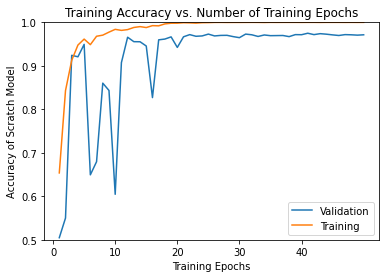

50


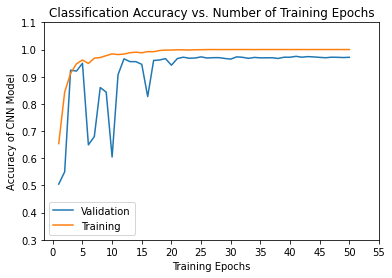

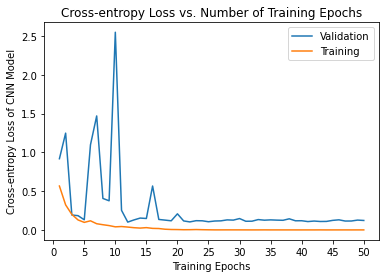

tensor([[2424.,   76.],
        [  49., 2451.]])
[2473. 2527.]
[[0.9696 0.0304]
 [0.0196 0.9804]]



Fold- 1 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                               | 0/50 [00:00<?, ?it/s]



----------
Epoch 0/49
LR 1e-05
[[4831. 2669.]
 [2582. 4918.]]
train: CE: 0.610712, MSE: 0.138610, loss: 0.563502
train Acc: 0.6499
train Bal. Acc: 0.6499


num_epochs:   2%|█▎                                                                  | 1/50 [06:28<5:17:28, 388.74s/it]

[[  56. 2444.]
 [   0. 2500.]]
val: CE: 0.890122, MSE: 0.132806, loss: 0.814390
val Acc: 0.5112
val Bal. Acc: 0.5112
saving best model
Total time: 0:06:28.742406
Epoch time: 6m 29s


----------
Epoch 1/49
LR 1e-05
[[6313. 1187.]
 [1212. 6288.]]
train: CE: 0.364785, MSE: 0.082752, loss: 0.336581
train Acc: 0.8401
train Bal. Acc: 0.8401


num_epochs:   4%|██▋                                                                 | 2/50 [12:57<5:11:02, 388.80s/it]

[[ 726. 1774.]
 [   0. 2500.]]
val: CE: 0.785523, MSE: 0.013400, loss: 0.708311
val Acc: 0.6452
val Bal. Acc: 0.6452
saving best model
Total time: 0:12:57.582541
Epoch time: 6m 29s


----------
Epoch 2/49
LR 1e-05
[[6791.  709.]
 [ 577. 6923.]]
train: CE: 0.221347, MSE: 0.008742, loss: 0.200087
train Acc: 0.9143
train Bal. Acc: 0.9143


num_epochs:   6%|████                                                                | 3/50 [19:26<5:04:42, 389.00s/it]

[[ 733. 1767.]
 [   0. 2500.]]
val: CE: 0.907338, MSE: 0.007583, loss: 0.817362
val Acc: 0.6466
val Bal. Acc: 0.6466
saving best model
Total time: 0:19:26.821834
Epoch time: 6m 29s


----------
Epoch 3/49
LR 1e-05
[[6981.  519.]
 [ 302. 7198.]]
train: CE: 0.153567, MSE: 0.006427, loss: 0.138853
train Acc: 0.9453
train Bal. Acc: 0.9453


num_epochs:   8%|█████▍                                                              | 4/50 [25:56<4:58:30, 389.35s/it]

[[2482.   18.]
 [1066. 1434.]]
val: CE: 0.592264, MSE: 0.005329, loss: 0.533570
val Acc: 0.7832
val Bal. Acc: 0.7832
saving best model
Total time: 0:25:56.707725
Epoch time: 6m 30s


----------
Epoch 4/49
LR 1e-05
[[7081.  419.]
 [ 190. 7310.]]
train: CE: 0.115072, MSE: 0.004343, loss: 0.103999
train Acc: 0.9594
train Bal. Acc: 0.9594


num_epochs:  10%|██████▊                                                             | 5/50 [32:25<4:51:56, 389.25s/it]

[[2488.   12.]
 [ 730. 1770.]]
val: CE: 0.373518, MSE: 0.003902, loss: 0.336556
val Acc: 0.8516
val Bal. Acc: 0.8516
saving best model
Total time: 0:32:25.785821
Epoch time: 6m 29s


----------
Epoch 5/49
LR 5e-05
[[6910.  590.]
 [ 301. 7199.]]
train: CE: 0.154973, MSE: 0.003533, loss: 0.139829
train Acc: 0.9406
train Bal. Acc: 0.9406


num_epochs:  12%|████████▏                                                           | 6/50 [38:54<4:45:21, 389.13s/it]

[[1442. 1058.]
 [   0. 2500.]]
val: CE: 0.530489, MSE: 0.002537, loss: 0.477694
val Acc: 0.7884
val Bal. Acc: 0.7884
Total time: 0:38:54.665704
Epoch time: 6m 29s


----------
Epoch 6/49
LR 5e-05
[[7083.  417.]
 [ 191. 7309.]]
train: CE: 0.109274, MSE: 0.002023, loss: 0.098548
train Acc: 0.9595
train Bal. Acc: 0.9595


num_epochs:  14%|█████████▌                                                          | 7/50 [45:22<4:38:40, 388.86s/it]

[[2419.   81.]
 [ 123. 2377.]]
val: CE: 0.123688, MSE: 0.001782, loss: 0.111498
val Acc: 0.9592
val Bal. Acc: 0.9592
saving best model
Total time: 0:45:22.977283
Epoch time: 6m 28s


----------
Epoch 7/49
LR 5e-05
[[7192.  308.]
 [ 121. 7379.]]
train: CE: 0.075806, MSE: 0.001556, loss: 0.068381
train Acc: 0.9714
train Bal. Acc: 0.9714


num_epochs:  16%|██████████▉                                                         | 8/50 [51:51<4:32:05, 388.71s/it]

[[2435.   65.]
 [ 129. 2371.]]
val: CE: 0.100164, MSE: 0.001514, loss: 0.090299
val Acc: 0.9612
val Bal. Acc: 0.9612
saving best model
Total time: 0:51:51.354031
Epoch time: 6m 28s


----------
Epoch 8/49
LR 5e-05
[[7255.  245.]
 [ 103. 7397.]]
train: CE: 0.063469, MSE: 0.001317, loss: 0.057254
train Acc: 0.9768
train Bal. Acc: 0.9768


num_epochs:  18%|████████████▏                                                       | 9/50 [58:20<4:25:38, 388.75s/it]

[[1.855e+03 6.450e+02]
 [2.000e+00 2.498e+03]]
val: CE: 0.424996, MSE: 0.001357, loss: 0.382632
val Acc: 0.8706
val Bal. Acc: 0.8706
Total time: 0:58:20.190177
Epoch time: 6m 29s


----------
Epoch 9/49
LR 5e-05
[[7309.  191.]
 [  93. 7407.]]
train: CE: 0.050309, MSE: 0.001171, loss: 0.045395
train Acc: 0.9811
train Bal. Acc: 0.9811


num_epochs:  20%|█████████████                                                    | 10/50 [1:04:49<4:19:10, 388.77s/it]

[[1.445e+03 1.055e+03]
 [1.000e+00 2.499e+03]]
val: CE: 0.849060, MSE: 0.001214, loss: 0.764276
val Acc: 0.7888
val Bal. Acc: 0.7888
Total time: 1:04:49.015245
Epoch time: 6m 29s


----------
Epoch 10/49
LR 5e-05
[[7339.  161.]
 [  86. 7414.]]
train: CE: 0.045183, MSE: 0.001065, loss: 0.040771
train Acc: 0.9835
train Bal. Acc: 0.9835


num_epochs:  22%|██████████████▎                                                  | 11/50 [1:11:16<4:12:32, 388.52s/it]

[[2336.  164.]
 [  28. 2472.]]
val: CE: 0.102827, MSE: 0.001128, loss: 0.092657
val Acc: 0.9616
val Bal. Acc: 0.9616
saving best model
Total time: 1:11:16.980916
Epoch time: 6m 28s


----------
Epoch 11/49
LR 5e-05
[[7362.  138.]
 [  67. 7433.]]
train: CE: 0.036213, MSE: 0.000998, loss: 0.032692
train Acc: 0.9863
train Bal. Acc: 0.9863


num_epochs:  24%|███████████████▌                                                 | 12/50 [1:17:46<4:06:13, 388.77s/it]

[[ 645. 1855.]
 [   0. 2500.]]
val: CE: 1.540679, MSE: 0.001077, loss: 1.386719
val Acc: 0.6290
val Bal. Acc: 0.6290
Total time: 1:17:46.318358
Epoch time: 6m 29s


----------
Epoch 12/49
LR 5e-05
[[7384.  116.]
 [  86. 7414.]]
train: CE: 0.034115, MSE: 0.000954, loss: 0.030799
train Acc: 0.9865
train Bal. Acc: 0.9865


num_epochs:  26%|████████████████▉                                                | 13/50 [1:24:15<3:59:47, 388.85s/it]

[[1.821e+03 6.790e+02]
 [1.000e+00 2.499e+03]]
val: CE: 0.474388, MSE: 0.001037, loss: 0.427053
val Acc: 0.8640
val Bal. Acc: 0.8640
Epoch     8: reducing learning rate of group 0 to 2.5000e-05.
Total time: 1:24:15.364197
Epoch time: 6m 29s


----------
Epoch 13/49
LR 2.5e-05
[[7448.   52.]
 [  37. 7463.]]
train: CE: 0.018647, MSE: 0.000926, loss: 0.016875
train Acc: 0.9941
train Bal. Acc: 0.9941


num_epochs:  28%|██████████████████▏                                              | 14/50 [1:30:44<3:53:18, 388.84s/it]

[[2399.  101.]
 [  33. 2467.]]
val: CE: 0.079894, MSE: 0.001021, loss: 0.072007
val Acc: 0.9732
val Bal. Acc: 0.9732
saving best model
Total time: 1:30:44.156103
Epoch time: 6m 29s


----------
Epoch 14/49
LR 2.5e-05
[[7458.   42.]
 [  32. 7468.]]
train: CE: 0.013937, MSE: 0.000912, loss: 0.012634
train Acc: 0.9951
train Bal. Acc: 0.9951


num_epochs:  30%|███████████████████▌                                             | 15/50 [1:37:12<3:46:47, 388.78s/it]

[[2450.   50.]
 [  88. 2412.]]
val: CE: 0.087936, MSE: 0.001007, loss: 0.079243
val Acc: 0.9724
val Bal. Acc: 0.9724
Total time: 1:37:12.816323
Epoch time: 6m 29s


----------
Epoch 15/49
LR 2.5e-05
[[7472.   28.]
 [  17. 7483.]]
train: CE: 0.009225, MSE: 0.000901, loss: 0.008392
train Acc: 0.9970
train Bal. Acc: 0.9970


num_epochs:  32%|████████████████████▊                                            | 16/50 [1:43:41<3:40:16, 388.73s/it]

[[2432.   68.]
 [  53. 2447.]]
val: CE: 0.085751, MSE: 0.000995, loss: 0.077276
val Acc: 0.9758
val Bal. Acc: 0.9758
saving best model
Total time: 1:43:41.421520
Epoch time: 6m 29s


----------
Epoch 16/49
LR 2.5e-05
[[7472.   28.]
 [  17. 7483.]]
train: CE: 0.008905, MSE: 0.000889, loss: 0.008104
train Acc: 0.9970
train Bal. Acc: 0.9970


num_epochs:  34%|██████████████████████                                           | 17/50 [1:50:10<3:33:49, 388.78s/it]

[[2.499e+03 1.000e+00]
 [6.860e+02 1.814e+03]]
val: CE: 0.706821, MSE: 0.000984, loss: 0.636238
val Acc: 0.8626
val Bal. Acc: 0.8626
Total time: 1:50:10.318430
Epoch time: 6m 29s


----------
Epoch 17/49
LR 2.5e-05
[[7484.   16.]
 [  14. 7486.]]
train: CE: 0.006514, MSE: 0.000879, loss: 0.005950
train Acc: 0.9980
train Bal. Acc: 0.9980


num_epochs:  36%|███████████████████████▍                                         | 18/50 [1:56:38<3:27:18, 388.70s/it]

[[2415.   85.]
 [  32. 2468.]]
val: CE: 0.090993, MSE: 0.000974, loss: 0.081991
val Acc: 0.9766
val Bal. Acc: 0.9766
saving best model
Total time: 1:56:38.843044
Epoch time: 6m 29s


----------
Epoch 18/49
LR 2.5e-05
[[7477.   23.]
 [  17. 7483.]]
train: CE: 0.008010, MSE: 0.000870, loss: 0.007296
train Acc: 0.9973
train Bal. Acc: 0.9973


num_epochs:  38%|████████████████████████▋                                        | 19/50 [2:03:06<3:20:42, 388.46s/it]

[[2398.  102.]
 [  32. 2468.]]
val: CE: 0.084180, MSE: 0.000965, loss: 0.075859
val Acc: 0.9732
val Bal. Acc: 0.9732
Total time: 2:03:06.723284
Epoch time: 6m 28s


----------
Epoch 19/49
LR 2.5e-05
[[7487.   13.]
 [   8. 7492.]]
train: CE: 0.004696, MSE: 0.000862, loss: 0.004313
train Acc: 0.9986
train Bal. Acc: 0.9986


num_epochs:  40%|██████████████████████████                                       | 20/50 [2:09:35<3:14:14, 388.47s/it]

[[2488.   12.]
 [ 302. 2198.]]
val: CE: 0.253955, MSE: 0.000957, loss: 0.228655
val Acc: 0.9372
val Bal. Acc: 0.9372
Epoch    15: reducing learning rate of group 0 to 1.2500e-05.
Total time: 2:09:35.228878
Epoch time: 6m 29s


----------
Epoch 20/49
LR 1.25e-05
[[7.491e+03 9.000e+00]
 [6.000e+00 7.494e+03]]
train: CE: 0.003308, MSE: 0.000856, loss: 0.003063
train Acc: 0.9990
train Bal. Acc: 0.9990


num_epochs:  42%|███████████████████████████▎                                     | 21/50 [2:16:03<3:07:47, 388.52s/it]

[[2387.  113.]
 [  29. 2471.]]
val: CE: 0.093967, MSE: 0.000953, loss: 0.084665
val Acc: 0.9716
val Bal. Acc: 0.9716
Total time: 2:16:03.875680
Epoch time: 6m 29s


----------
Epoch 21/49
LR 1.25e-05
[[7.495e+03 5.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.002290, MSE: 0.000852, loss: 0.002146
train Acc: 0.9995
train Bal. Acc: 0.9995


num_epochs:  44%|████████████████████████████▌                                    | 22/50 [2:22:32<3:01:19, 388.54s/it]

[[2411.   89.]
 [  30. 2470.]]
val: CE: 0.088191, MSE: 0.000950, loss: 0.079467
val Acc: 0.9762
val Bal. Acc: 0.9762
Total time: 2:22:32.450783
Epoch time: 6m 29s


----------
Epoch 22/49
LR 1.25e-05
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001398, MSE: 0.000849, loss: 0.001343
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  46%|█████████████████████████████▉                                   | 23/50 [2:29:01<2:54:54, 388.68s/it]

[[2427.   73.]
 [  43. 2457.]]
val: CE: 0.082034, MSE: 0.000946, loss: 0.073926
val Acc: 0.9768
val Bal. Acc: 0.9768
saving best model
Total time: 2:29:01.475685
Epoch time: 6m 29s


----------
Epoch 23/49
LR 1.25e-05
[[7.493e+03 7.000e+00]
 [6.000e+00 7.494e+03]]
train: CE: 0.002402, MSE: 0.000846, loss: 0.002247
train Acc: 0.9991
train Bal. Acc: 0.9991


num_epochs:  48%|███████████████████████████████▏                                 | 24/50 [2:35:30<2:48:29, 388.82s/it]

[[2408.   92.]
 [  31. 2469.]]
val: CE: 0.093675, MSE: 0.000943, loss: 0.084402
val Acc: 0.9754
val Bal. Acc: 0.9754
Total time: 2:35:30.594709
Epoch time: 6m 29s


----------
Epoch 24/49
LR 1.25e-05
[[7.494e+03 6.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.002209, MSE: 0.000842, loss: 0.002072
train Acc: 0.9994
train Bal. Acc: 0.9994


num_epochs:  50%|████████████████████████████████▌                                | 25/50 [2:41:59<2:41:58, 388.73s/it]

[[2391.  109.]
 [  28. 2472.]]
val: CE: 0.104935, MSE: 0.000940, loss: 0.094535
val Acc: 0.9726
val Bal. Acc: 0.9726
Total time: 2:41:59.122977
Epoch time: 6m 29s


----------
Epoch 25/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [4.000e+00 7.496e+03]]
train: CE: 0.001813, MSE: 0.000839, loss: 0.001716
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  52%|█████████████████████████████████▊                               | 26/50 [2:48:27<2:35:28, 388.69s/it]

[[2465.   35.]
 [  80. 2420.]]
val: CE: 0.099582, MSE: 0.000937, loss: 0.089718
val Acc: 0.9770
val Bal. Acc: 0.9770
saving best model
Total time: 2:48:27.705773
Epoch time: 6m 29s


----------
Epoch 26/49
LR 1.25e-05
[[7.493e+03 7.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.002163, MSE: 0.000837, loss: 0.002030
train Acc: 0.9993
train Bal. Acc: 0.9993


num_epochs:  54%|███████████████████████████████████                              | 27/50 [2:54:55<2:28:56, 388.54s/it]

[[2423.   77.]
 [  39. 2461.]]
val: CE: 0.092388, MSE: 0.000934, loss: 0.083242
val Acc: 0.9768
val Bal. Acc: 0.9768
Epoch    22: reducing learning rate of group 0 to 6.2500e-06.
Total time: 2:54:55.902756
Epoch time: 6m 28s


----------
Epoch 27/49
LR 6.25e-06
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000929, MSE: 0.000834, loss: 0.000920
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  56%|████████████████████████████████████▍                            | 28/50 [3:01:23<2:22:23, 388.34s/it]

[[2413.   87.]
 [  31. 2469.]]
val: CE: 0.090721, MSE: 0.000932, loss: 0.081742
val Acc: 0.9764
val Bal. Acc: 0.9764
Total time: 3:01:23.776295
Epoch time: 6m 28s


----------
Epoch 28/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000567, MSE: 0.000833, loss: 0.000593
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  58%|█████████████████████████████████████▋                           | 29/50 [3:07:52<2:15:57, 388.47s/it]

[[2438.   62.]
 [  43. 2457.]]
val: CE: 0.082250, MSE: 0.000931, loss: 0.074118
val Acc: 0.9790
val Bal. Acc: 0.9790
saving best model
Total time: 3:07:52.554220
Epoch time: 6m 29s


----------
Epoch 29/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000752, MSE: 0.000831, loss: 0.000760
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  60%|███████████████████████████████████████                          | 30/50 [3:14:21<2:09:29, 388.49s/it]

[[2430.   70.]
 [  41. 2459.]]
val: CE: 0.085456, MSE: 0.000929, loss: 0.077003
val Acc: 0.9778
val Bal. Acc: 0.9778
Total time: 3:14:21.105608
Epoch time: 6m 29s


----------
Epoch 30/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.001075, MSE: 0.000830, loss: 0.001051
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  62%|████████████████████████████████████████▎                        | 31/50 [3:20:49<2:03:02, 388.54s/it]

[[2435.   65.]
 [  44. 2456.]]
val: CE: 0.085462, MSE: 0.000928, loss: 0.077008
val Acc: 0.9782
val Bal. Acc: 0.9782
Total time: 3:20:49.736009
Epoch time: 6m 29s


----------
Epoch 31/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000483, MSE: 0.000829, loss: 0.000517
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  64%|█████████████████████████████████████████▌                       | 32/50 [3:27:18<1:56:35, 388.63s/it]

[[2417.   83.]
 [  33. 2467.]]
val: CE: 0.087115, MSE: 0.000926, loss: 0.078496
val Acc: 0.9768
val Bal. Acc: 0.9768
Total time: 3:27:18.602346
Epoch time: 6m 29s


----------
Epoch 32/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000557, MSE: 0.000827, loss: 0.000584
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  66%|██████████████████████████████████████████▉                      | 33/50 [3:33:47<1:50:06, 388.63s/it]

[[2415.   85.]
 [  31. 2469.]]
val: CE: 0.089228, MSE: 0.000925, loss: 0.080398
val Acc: 0.9768
val Bal. Acc: 0.9768
Total time: 3:33:47.237374
Epoch time: 6m 29s


----------
Epoch 33/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000376, MSE: 0.000826, loss: 0.000421
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  68%|████████████████████████████████████████████▏                    | 34/50 [3:40:15<1:43:36, 388.55s/it]

[[2436.   64.]
 [  40. 2460.]]
val: CE: 0.082280, MSE: 0.000923, loss: 0.074145
val Acc: 0.9792
val Bal. Acc: 0.9792
saving best model
Epoch    29: reducing learning rate of group 0 to 3.1250e-06.
Total time: 3:40:15.597915
Epoch time: 6m 28s


----------
Epoch 34/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000587, MSE: 0.000825, loss: 0.000610
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  70%|█████████████████████████████████████████████▌                   | 35/50 [3:46:44<1:37:08, 388.59s/it]

[[2427.   73.]
 [  33. 2467.]]
val: CE: 0.086845, MSE: 0.000922, loss: 0.078253
val Acc: 0.9788
val Bal. Acc: 0.9788
Total time: 3:46:44.289509
Epoch time: 6m 29s


----------
Epoch 35/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000561, MSE: 0.000824, loss: 0.000587
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  72%|██████████████████████████████████████████████▊                  | 36/50 [3:53:12<1:30:38, 388.49s/it]

[[2444.   56.]
 [  43. 2457.]]
val: CE: 0.084178, MSE: 0.000922, loss: 0.075852
val Acc: 0.9802
val Bal. Acc: 0.9802
saving best model
Total time: 3:53:12.547531
Epoch time: 6m 28s


----------
Epoch 36/49
LR 3.125e-06
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000635, MSE: 0.000823, loss: 0.000654
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  74%|████████████████████████████████████████████████                 | 37/50 [3:59:40<1:24:09, 388.43s/it]

[[2436.   64.]
 [  39. 2461.]]
val: CE: 0.082329, MSE: 0.000921, loss: 0.074188
val Acc: 0.9794
val Bal. Acc: 0.9794
Total time: 3:59:40.844599
Epoch time: 6m 28s


----------
Epoch 37/49
LR 3.125e-06
[[7.496e+03 4.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001405, MSE: 0.000822, loss: 0.001347
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  76%|█████████████████████████████████████████████████▍               | 38/50 [4:06:08<1:17:39, 388.33s/it]

[[2437.   63.]
 [  48. 2452.]]
val: CE: 0.088891, MSE: 0.000920, loss: 0.080094
val Acc: 0.9778
val Bal. Acc: 0.9778
Total time: 4:06:08.935957
Epoch time: 6m 28s


----------
Epoch 38/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000491, MSE: 0.000822, loss: 0.000524
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  78%|██████████████████████████████████████████████████▋              | 39/50 [4:12:37<1:11:10, 388.26s/it]

[[2417.   83.]
 [  32. 2468.]]
val: CE: 0.090781, MSE: 0.000920, loss: 0.081795
val Acc: 0.9770
val Bal. Acc: 0.9770
Total time: 4:12:37.013918
Epoch time: 6m 28s


----------
Epoch 39/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000723, MSE: 0.000821, loss: 0.000733
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  80%|████████████████████████████████████████████████████             | 40/50 [4:19:05<1:04:43, 388.33s/it]

[[2433.   67.]
 [  41. 2459.]]
val: CE: 0.086988, MSE: 0.000919, loss: 0.078381
val Acc: 0.9784
val Bal. Acc: 0.9784
Total time: 4:19:05.505233
Epoch time: 6m 28s


----------
Epoch 40/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000430, MSE: 0.000820, loss: 0.000469
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  82%|██████████████████████████████████████████████████████▉            | 41/50 [4:25:33<58:14, 388.28s/it]

[[2431.   69.]
 [  36. 2464.]]
val: CE: 0.084496, MSE: 0.000918, loss: 0.076139
val Acc: 0.9790
val Bal. Acc: 0.9790
Epoch    36: reducing learning rate of group 0 to 1.5625e-06.
Total time: 4:25:33.676939
Epoch time: 6m 28s


----------
Epoch 41/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000349, MSE: 0.000820, loss: 0.000396
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  84%|████████████████████████████████████████████████████████▎          | 42/50 [4:32:02<51:46, 388.30s/it]

[[2410.   90.]
 [  31. 2469.]]
val: CE: 0.090489, MSE: 0.000918, loss: 0.081532
val Acc: 0.9758
val Bal. Acc: 0.9758
Total time: 4:32:02.030736
Epoch time: 6m 28s


----------
Epoch 42/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000328, MSE: 0.000819, loss: 0.000377
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  86%|█████████████████████████████████████████████████████████▌         | 43/50 [4:38:30<45:19, 388.46s/it]

[[2439.   61.]
 [  42. 2458.]]
val: CE: 0.083478, MSE: 0.000917, loss: 0.075222
val Acc: 0.9794
val Bal. Acc: 0.9794
Total time: 4:38:30.864510
Epoch time: 6m 29s


----------
Epoch 43/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000520, MSE: 0.000819, loss: 0.000550
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  88%|██████████████████████████████████████████████████████████▉        | 44/50 [4:44:59<38:50, 388.48s/it]

[[2418.   82.]
 [  32. 2468.]]
val: CE: 0.089630, MSE: 0.000917, loss: 0.080759
val Acc: 0.9772
val Bal. Acc: 0.9772
Total time: 4:44:59.388894
Epoch time: 6m 29s


----------
Epoch 44/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000390, MSE: 0.000819, loss: 0.000433
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  90%|████████████████████████████████████████████████████████████▎      | 45/50 [4:51:27<32:22, 388.40s/it]

[[2407.   93.]
 [  30. 2470.]]
val: CE: 0.094863, MSE: 0.000917, loss: 0.085469
val Acc: 0.9754
val Bal. Acc: 0.9754
Total time: 4:51:27.612857
Epoch time: 6m 28s


----------
Epoch 45/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000324, MSE: 0.000818, loss: 0.000373
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [4:57:55<25:53, 388.30s/it]

[[2417.   83.]
 [  33. 2467.]]
val: CE: 0.089801, MSE: 0.000916, loss: 0.080912
val Acc: 0.9768
val Bal. Acc: 0.9768
Total time: 4:57:55.654946
Epoch time: 6m 28s


----------
Epoch 46/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000573, MSE: 0.000818, loss: 0.000598
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [5:04:23<19:24, 388.14s/it]

[[2418.   82.]
 [  33. 2467.]]
val: CE: 0.090413, MSE: 0.000916, loss: 0.081463
val Acc: 0.9770
val Bal. Acc: 0.9770
Total time: 5:04:23.449074
Epoch time: 6m 28s


----------
Epoch 47/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000268, MSE: 0.000817, loss: 0.000323
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [5:10:51<12:56, 388.16s/it]

[[2435.   65.]
 [  41. 2459.]]
val: CE: 0.084629, MSE: 0.000915, loss: 0.076257
val Acc: 0.9788
val Bal. Acc: 0.9788
Epoch    43: reducing learning rate of group 0 to 7.8125e-07.
Total time: 5:10:51.658562
Epoch time: 6m 28s


----------
Epoch 48/49
LR 7.8125e-07
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000277, MSE: 0.000817, loss: 0.000331
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [5:17:19<06:28, 388.06s/it]

[[2424.   76.]
 [  36. 2464.]]
val: CE: 0.088547, MSE: 0.000915, loss: 0.079784
val Acc: 0.9776
val Bal. Acc: 0.9776
Total time: 5:17:19.487453
Epoch time: 6m 28s


----------
Epoch 49/49
LR 7.8125e-07
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000298, MSE: 0.000817, loss: 0.000350
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs: 100%|███████████████████████████████████████████████████████████████████| 50/50 [5:23:47<00:00, 388.56s/it]

[[2427.   73.]
 [  37. 2463.]]
val: CE: 0.085804, MSE: 0.000915, loss: 0.077315
val Acc: 0.9780
val Bal. Acc: 0.9780
Total time: 5:23:47.917950
Epoch time: 6m 28s
Best val loss: 0.075852
Best val acc: 0.980200
50


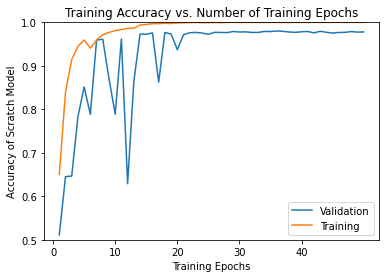

50


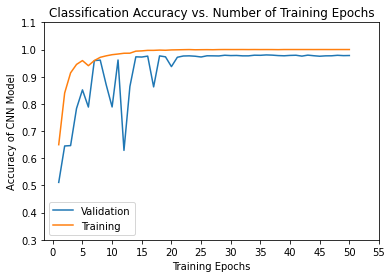

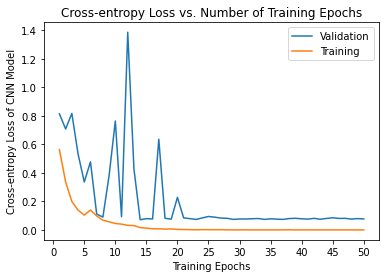

tensor([[2444.,   56.],
        [  43., 2457.]])
[2487. 2513.]
[[0.9776 0.0224]
 [0.0172 0.9828]]



Fold- 2 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                               | 0/50 [00:00<?, ?it/s]



----------
Epoch 0/49
LR 1e-05
[[4711. 2789.]
 [2216. 5284.]]
train: CE: 0.595763, MSE: 0.116978, loss: 0.547884
train Acc: 0.6663
train Bal. Acc: 0.6663


num_epochs:   2%|█▎                                                                  | 1/50 [06:27<5:16:47, 387.91s/it]

[[ 650. 1850.]
 [   5. 2495.]]
val: CE: 0.713219, MSE: 0.107673, loss: 0.652664
val Acc: 0.6290
val Bal. Acc: 0.6290
saving best model
Total time: 0:06:27.910888
Epoch time: 6m 28s


----------
Epoch 1/49
LR 1e-05
[[6261. 1239.]
 [1196. 6304.]]
train: CE: 0.363496, MSE: 0.054743, loss: 0.332621
train Acc: 0.8377
train Bal. Acc: 0.8377


num_epochs:   4%|██▋                                                                 | 2/50 [12:56<5:10:35, 388.23s/it]

[[ 711. 1789.]
 [   0. 2500.]]
val: CE: 0.706753, MSE: 0.009898, loss: 0.637068
val Acc: 0.6422
val Bal. Acc: 0.6422
saving best model
Total time: 0:12:56.369579
Epoch time: 6m 28s


----------
Epoch 2/49
LR 1e-05
[[6753.  747.]
 [ 527. 6973.]]
train: CE: 0.224757, MSE: 0.008239, loss: 0.203105
train Acc: 0.9151
train Bal. Acc: 0.9151


num_epochs:   6%|████                                                                | 3/50 [19:25<5:04:20, 388.52s/it]

[[2461.   39.]
 [ 757. 1743.]]
val: CE: 0.350238, MSE: 0.006951, loss: 0.315909
val Acc: 0.8408
val Bal. Acc: 0.8408
saving best model
Total time: 0:19:25.239998
Epoch time: 6m 29s


----------
Epoch 3/49
LR 1e-05
[[6912.  588.]
 [ 343. 7157.]]
train: CE: 0.166673, MSE: 0.005905, loss: 0.150597
train Acc: 0.9379
train Bal. Acc: 0.9379


num_epochs:   8%|█████▍                                                              | 4/50 [25:53<4:57:49, 388.46s/it]

[[2476.   24.]
 [ 813. 1687.]]
val: CE: 0.411978, MSE: 0.003999, loss: 0.371180
val Acc: 0.8326
val Bal. Acc: 0.8326
Total time: 0:25:53.602986
Epoch time: 6m 28s


----------
Epoch 4/49
LR 1e-05
[[7047.  453.]
 [ 240. 7260.]]
train: CE: 0.125892, MSE: 0.003517, loss: 0.113654
train Acc: 0.9538
train Bal. Acc: 0.9538


num_epochs:  10%|██████▊                                                             | 5/50 [32:22<4:51:24, 388.54s/it]

[[2471.   29.]
 [ 485. 2015.]]
val: CE: 0.249166, MSE: 0.003102, loss: 0.224560
val Acc: 0.8972
val Bal. Acc: 0.8972
saving best model
Total time: 0:32:22.272369
Epoch time: 6m 29s


----------
Epoch 5/49
LR 5e-05
[[6796.  704.]
 [ 360. 7140.]]
train: CE: 0.186474, MSE: 0.003797, loss: 0.168206
train Acc: 0.9291
train Bal. Acc: 0.9291


num_epochs:  12%|████████▏                                                           | 6/50 [38:50<4:44:50, 388.42s/it]

[[1.550e+03 9.500e+02]
 [1.000e+00 2.499e+03]]
val: CE: 0.630312, MSE: 0.003362, loss: 0.567617
val Acc: 0.8098
val Bal. Acc: 0.8098
Total time: 0:38:50.462671
Epoch time: 6m 28s


----------
Epoch 6/49
LR 5e-05
[[7054.  446.]
 [ 222. 7278.]]
train: CE: 0.114286, MSE: 0.002735, loss: 0.103131
train Acc: 0.9555
train Bal. Acc: 0.9555


num_epochs:  14%|█████████▌                                                          | 7/50 [45:18<4:38:13, 388.23s/it]

[[  62. 2438.]
 [   0. 2500.]]
val: CE: 2.320266, MSE: 0.002249, loss: 2.088465
val Acc: 0.5124
val Bal. Acc: 0.5124
Total time: 0:45:18.306017
Epoch time: 6m 28s


----------
Epoch 7/49
LR 5e-05
[[7134.  366.]
 [ 184. 7316.]]
train: CE: 0.094116, MSE: 0.002163, loss: 0.084920
train Acc: 0.9633
train Bal. Acc: 0.9633


num_epochs:  16%|██████████▉                                                         | 8/50 [51:46<4:31:48, 388.29s/it]

[[ 521. 1979.]
 [   0. 2500.]]
val: CE: 1.885725, MSE: 0.001735, loss: 1.697326
val Acc: 0.6042
val Bal. Acc: 0.6042
Total time: 0:51:46.728167
Epoch time: 6m 28s


----------
Epoch 8/49
LR 5e-05
[[7238.  262.]
 [ 144. 7356.]]
train: CE: 0.070057, MSE: 0.001557, loss: 0.063207
train Acc: 0.9729
train Bal. Acc: 0.9729


num_epochs:  18%|████████████▏                                                       | 9/50 [58:15<4:25:24, 388.41s/it]

[[2466.   34.]
 [ 193. 2307.]]
val: CE: 0.125746, MSE: 0.001267, loss: 0.113298
val Acc: 0.9546
val Bal. Acc: 0.9546
saving best model
Total time: 0:58:15.393660
Epoch time: 6m 29s


----------
Epoch 9/49
LR 5e-05
[[7289.  211.]
 [ 112. 7388.]]
train: CE: 0.056794, MSE: 0.001277, loss: 0.051243
train Acc: 0.9785
train Bal. Acc: 0.9785


num_epochs:  20%|█████████████                                                    | 10/50 [1:04:43<4:18:53, 388.35s/it]

[[2422.   78.]
 [  51. 2449.]]
val: CE: 0.070456, MSE: 0.001151, loss: 0.063525
val Acc: 0.9742
val Bal. Acc: 0.9742
saving best model
Total time: 1:04:43.612742
Epoch time: 6m 28s


----------
Epoch 10/49
LR 5e-05
[[7333.  167.]
 [  98. 7402.]]
train: CE: 0.048046, MSE: 0.001210, loss: 0.043363
train Acc: 0.9823
train Bal. Acc: 0.9823


num_epochs:  22%|██████████████▎                                                  | 11/50 [1:11:12<4:12:27, 388.40s/it]

[[2018.  482.]
 [   0. 2500.]]
val: CE: 0.341938, MSE: 0.001132, loss: 0.307858
val Acc: 0.9036
val Bal. Acc: 0.9036
Total time: 1:11:12.111333
Epoch time: 6m 28s


----------
Epoch 11/49
LR 5e-05
[[7333.  167.]
 [ 114. 7386.]]
train: CE: 0.047808, MSE: 0.001181, loss: 0.043145
train Acc: 0.9813
train Bal. Acc: 0.9813


num_epochs:  24%|███████████████▌                                                 | 12/50 [1:17:40<4:05:54, 388.28s/it]

[[1919.  581.]
 [   4. 2496.]]
val: CE: 0.449178, MSE: 0.001101, loss: 0.404370
val Acc: 0.8830
val Bal. Acc: 0.8830
Total time: 1:17:40.133887
Epoch time: 6m 28s


----------
Epoch 12/49
LR 5e-05
[[7292.  208.]
 [ 116. 7384.]]
train: CE: 0.054064, MSE: 0.001240, loss: 0.048782
train Acc: 0.9784
train Bal. Acc: 0.9784


num_epochs:  26%|████████████████▉                                                | 13/50 [1:24:10<3:59:45, 388.80s/it]

[[2386.  114.]
 [  15. 2485.]]
val: CE: 0.081585, MSE: 0.001281, loss: 0.073555
val Acc: 0.9742
val Bal. Acc: 0.9742
Total time: 1:24:10.133706
Epoch time: 6m 30s


----------
Epoch 13/49
LR 5e-05
[[7368.  132.]
 [  80. 7420.]]
train: CE: 0.037842, MSE: 0.001094, loss: 0.034168
train Acc: 0.9859
train Bal. Acc: 0.9859


num_epochs:  28%|██████████████████▏                                              | 14/50 [1:30:39<3:53:27, 389.11s/it]

[[2314.  186.]
 [  15. 2485.]]
val: CE: 0.114317, MSE: 0.000987, loss: 0.102984
val Acc: 0.9598
val Bal. Acc: 0.9598
Total time: 1:30:39.949921
Epoch time: 6m 30s


----------
Epoch 14/49
LR 5e-05
[[7387.  113.]
 [  71. 7429.]]
train: CE: 0.033395, MSE: 0.001051, loss: 0.030161
train Acc: 0.9877
train Bal. Acc: 0.9877


num_epochs:  30%|███████████████████▌                                             | 15/50 [1:37:09<3:47:08, 389.37s/it]

[[2464.   36.]
 [  84. 2416.]]
val: CE: 0.079190, MSE: 0.001322, loss: 0.071403
val Acc: 0.9760
val Bal. Acc: 0.9760
saving best model
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Total time: 1:37:09.933490
Epoch time: 6m 30s


----------
Epoch 15/49
LR 2.5e-05
[[7430.   70.]
 [  45. 7455.]]
train: CE: 0.021808, MSE: 0.001094, loss: 0.019736
train Acc: 0.9923
train Bal. Acc: 0.9923


num_epochs:  32%|████████████████████▊                                            | 16/50 [1:43:38<3:40:27, 389.04s/it]

[[2468.   32.]
 [  97. 2403.]]
val: CE: 0.077551, MSE: 0.000974, loss: 0.069893
val Acc: 0.9742
val Bal. Acc: 0.9742
Total time: 1:43:38.209219
Epoch time: 6m 28s


----------
Epoch 16/49
LR 2.5e-05
[[7454.   46.]
 [  40. 7460.]]
train: CE: 0.016361, MSE: 0.001018, loss: 0.014827
train Acc: 0.9943
train Bal. Acc: 0.9943


num_epochs:  34%|██████████████████████                                           | 17/50 [1:50:07<3:33:56, 389.00s/it]

[[2442.   58.]
 [  43. 2457.]]
val: CE: 0.061535, MSE: 0.000971, loss: 0.055479
val Acc: 0.9798
val Bal. Acc: 0.9798
saving best model
Total time: 1:50:07.102043
Epoch time: 6m 29s


----------
Epoch 17/49
LR 2.5e-05
[[7465.   35.]
 [  34. 7466.]]
train: CE: 0.013093, MSE: 0.000996, loss: 0.011883
train Acc: 0.9954
train Bal. Acc: 0.9954


num_epochs:  36%|███████████████████████▍                                         | 18/50 [1:56:36<3:27:27, 388.98s/it]

[[2443.   57.]
 [  34. 2466.]]
val: CE: 0.057224, MSE: 0.000925, loss: 0.051594
val Acc: 0.9818
val Bal. Acc: 0.9818
saving best model
Total time: 1:56:36.044111
Epoch time: 6m 29s


----------
Epoch 18/49
LR 2.5e-05
[[7482.   18.]
 [  14. 7486.]]
train: CE: 0.007121, MSE: 0.000987, loss: 0.006508
train Acc: 0.9979
train Bal. Acc: 0.9979


num_epochs:  38%|████████████████████████▋                                        | 19/50 [2:03:04<3:20:57, 388.94s/it]

[[2458.   42.]
 [  48. 2452.]]
val: CE: 0.070781, MSE: 0.000947, loss: 0.063798
val Acc: 0.9820
val Bal. Acc: 0.9820
saving best model
Total time: 2:03:04.889485
Epoch time: 6m 29s


----------
Epoch 19/49
LR 2.5e-05
[[7474.   26.]
 [  13. 7487.]]
train: CE: 0.008872, MSE: 0.000982, loss: 0.008083
train Acc: 0.9974
train Bal. Acc: 0.9974


num_epochs:  40%|██████████████████████████                                       | 20/50 [2:09:33<3:14:28, 388.94s/it]

[[2454.   46.]
 [  43. 2457.]]
val: CE: 0.058400, MSE: 0.000913, loss: 0.052651
val Acc: 0.9822
val Bal. Acc: 0.9822
saving best model
Total time: 2:09:33.845252
Epoch time: 6m 29s


----------
Epoch 20/49
LR 2.5e-05
[[7464.   36.]
 [  28. 7472.]]
train: CE: 0.011890, MSE: 0.000981, loss: 0.010799
train Acc: 0.9957
train Bal. Acc: 0.9957


num_epochs:  42%|███████████████████████████▎                                     | 21/50 [2:16:02<3:08:01, 389.00s/it]

[[2465.   35.]
 [  71. 2429.]]
val: CE: 0.079080, MSE: 0.000916, loss: 0.071264
val Acc: 0.9788
val Bal. Acc: 0.9788
Total time: 2:16:02.976916
Epoch time: 6m 29s


----------
Epoch 21/49
LR 2.5e-05
[[7470.   30.]
 [  26. 7474.]]
train: CE: 0.009921, MSE: 0.000972, loss: 0.009026
train Acc: 0.9963
train Bal. Acc: 0.9963


num_epochs:  44%|████████████████████████████▌                                    | 22/50 [2:22:32<3:01:32, 389.02s/it]

[[2453.   47.]
 [  55. 2445.]]
val: CE: 0.064169, MSE: 0.000902, loss: 0.057843
val Acc: 0.9796
val Bal. Acc: 0.9796
Total time: 2:22:32.025787
Epoch time: 6m 29s


----------
Epoch 22/49
LR 2.5e-05
[[7484.   16.]
 [  14. 7486.]]
train: CE: 0.005879, MSE: 0.000963, loss: 0.005388
train Acc: 0.9980
train Bal. Acc: 0.9980


num_epochs:  46%|█████████████████████████████▉                                   | 23/50 [2:29:00<2:54:57, 388.81s/it]

[[2470.   30.]
 [  88. 2412.]]
val: CE: 0.082547, MSE: 0.000900, loss: 0.074382
val Acc: 0.9764
val Bal. Acc: 0.9764
Epoch    18: reducing learning rate of group 0 to 1.2500e-05.
Total time: 2:29:00.344664
Epoch time: 6m 28s


----------
Epoch 23/49
LR 1.25e-05
[[7489.   11.]
 [   8. 7492.]]
train: CE: 0.003726, MSE: 0.000951, loss: 0.003449
train Acc: 0.9987
train Bal. Acc: 0.9987


num_epochs:  48%|███████████████████████████████▏                                 | 24/50 [2:35:28<2:48:22, 388.57s/it]

[[2435.   65.]
 [  27. 2473.]]
val: CE: 0.073098, MSE: 0.000891, loss: 0.065877
val Acc: 0.9816
val Bal. Acc: 0.9816
Total time: 2:35:28.367969
Epoch time: 6m 28s


----------
Epoch 24/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [5.000e+00 7.495e+03]]
train: CE: 0.002397, MSE: 0.000945, loss: 0.002251
train Acc: 0.9994
train Bal. Acc: 0.9994


num_epochs:  50%|████████████████████████████████▌                                | 25/50 [2:41:56<2:41:53, 388.55s/it]

[[2438.   62.]
 [  24. 2476.]]
val: CE: 0.067399, MSE: 0.000886, loss: 0.060747
val Acc: 0.9828
val Bal. Acc: 0.9828
saving best model
Total time: 2:41:56.875683
Epoch time: 6m 29s


----------
Epoch 25/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.001952, MSE: 0.000940, loss: 0.001850
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  52%|█████████████████████████████████▊                               | 26/50 [2:48:25<2:35:22, 388.45s/it]

[[2445.   55.]
 [  27. 2473.]]
val: CE: 0.063337, MSE: 0.000882, loss: 0.057091
val Acc: 0.9836
val Bal. Acc: 0.9836
saving best model
Total time: 2:48:25.088499
Epoch time: 6m 28s


----------
Epoch 26/49
LR 1.25e-05
[[7.499e+03 1.000e+00]
 [4.000e+00 7.496e+03]]
train: CE: 0.001549, MSE: 0.000937, loss: 0.001487
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  54%|███████████████████████████████████                              | 27/50 [2:54:53<2:28:54, 388.46s/it]

[[2434.   66.]
 [  20. 2480.]]
val: CE: 0.068502, MSE: 0.000880, loss: 0.061740
val Acc: 0.9828
val Bal. Acc: 0.9828
Total time: 2:54:53.563047
Epoch time: 6m 28s


----------
Epoch 27/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001356, MSE: 0.000933, loss: 0.001314
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  56%|████████████████████████████████████▍                            | 28/50 [3:01:22<2:22:26, 388.47s/it]

[[2460.   40.]
 [  37. 2463.]]
val: CE: 0.063387, MSE: 0.000876, loss: 0.057136
val Acc: 0.9846
val Bal. Acc: 0.9846
saving best model
Total time: 3:01:22.061966
Epoch time: 6m 28s


----------
Epoch 28/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [5.000e+00 7.495e+03]]
train: CE: 0.002031, MSE: 0.000931, loss: 0.001921
train Acc: 0.9994
train Bal. Acc: 0.9994


num_epochs:  58%|█████████████████████████████████████▋                           | 29/50 [3:07:50<2:15:55, 388.36s/it]

[[2437.   63.]
 [  21. 2479.]]
val: CE: 0.068360, MSE: 0.000874, loss: 0.061611
val Acc: 0.9832
val Bal. Acc: 0.9832
Total time: 3:07:50.166891
Epoch time: 6m 28s


----------
Epoch 29/49
LR 1.25e-05
[[7.494e+03 6.000e+00]
 [5.000e+00 7.495e+03]]
train: CE: 0.002118, MSE: 0.000929, loss: 0.001999
train Acc: 0.9993
train Bal. Acc: 0.9993


num_epochs:  60%|███████████████████████████████████████                          | 30/50 [3:14:19<2:09:31, 388.56s/it]

[[2428.   72.]
 [  18. 2482.]]
val: CE: 0.081083, MSE: 0.000870, loss: 0.073062
val Acc: 0.9820
val Bal. Acc: 0.9820
Epoch    25: reducing learning rate of group 0 to 6.2500e-06.
Total time: 3:14:19.194766
Epoch time: 6m 29s


----------
Epoch 30/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.001089, MSE: 0.000925, loss: 0.001073
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  62%|████████████████████████████████████████▎                        | 31/50 [3:20:48<2:03:05, 388.72s/it]

[[2456.   44.]
 [  33. 2467.]]
val: CE: 0.063197, MSE: 0.000868, loss: 0.056964
val Acc: 0.9846
val Bal. Acc: 0.9846
Total time: 3:20:48.295198
Epoch time: 6m 29s


----------
Epoch 31/49
LR 6.25e-06
[[7.497e+03 3.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001369, MSE: 0.000922, loss: 0.001325
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  64%|█████████████████████████████████████████▌                       | 32/50 [3:27:17<1:56:38, 388.80s/it]

[[2465.   35.]
 [  48. 2452.]]
val: CE: 0.068866, MSE: 0.000866, loss: 0.062066
val Acc: 0.9834
val Bal. Acc: 0.9834
Total time: 3:27:17.286927
Epoch time: 6m 29s


----------
Epoch 32/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [6.000e+00 7.494e+03]]
train: CE: 0.001458, MSE: 0.000921, loss: 0.001404
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  66%|██████████████████████████████████████████▉                      | 33/50 [3:33:47<1:50:15, 389.17s/it]

[[2468.   32.]
 [  49. 2451.]]
val: CE: 0.068850, MSE: 0.000865, loss: 0.062052
val Acc: 0.9838
val Bal. Acc: 0.9838
Total time: 3:33:47.322900
Epoch time: 6m 30s


----------
Epoch 33/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000671, MSE: 0.000920, loss: 0.000695
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  68%|████████████████████████████████████████████▏                    | 34/50 [3:40:16<1:43:45, 389.10s/it]

[[2461.   39.]
 [  34. 2466.]]
val: CE: 0.062718, MSE: 0.000864, loss: 0.056533
val Acc: 0.9854
val Bal. Acc: 0.9854
saving best model
Total time: 3:40:16.258500
Epoch time: 6m 29s


----------
Epoch 34/49
LR 6.25e-06
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000880, MSE: 0.000918, loss: 0.000883
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  70%|█████████████████████████████████████████████▌                   | 35/50 [3:46:44<1:37:12, 388.84s/it]

[[2460.   40.]
 [  45. 2455.]]
val: CE: 0.067817, MSE: 0.000862, loss: 0.061121
val Acc: 0.9830
val Bal. Acc: 0.9830
Total time: 3:46:44.472534
Epoch time: 6m 28s


----------
Epoch 35/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.000841, MSE: 0.000916, loss: 0.000848
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  72%|██████████████████████████████████████████████▊                  | 36/50 [3:53:13<1:30:42, 388.75s/it]

[[2463.   37.]
 [  41. 2459.]]
val: CE: 0.066325, MSE: 0.000860, loss: 0.059778
val Acc: 0.9844
val Bal. Acc: 0.9844
Total time: 3:53:13.033804
Epoch time: 6m 29s


----------
Epoch 36/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [4.000e+00 7.496e+03]]
train: CE: 0.001238, MSE: 0.000914, loss: 0.001205
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  74%|████████████████████████████████████████████████                 | 37/50 [3:59:41<1:24:12, 388.68s/it]

[[2452.   48.]
 [  27. 2473.]]
val: CE: 0.065003, MSE: 0.000859, loss: 0.058588
val Acc: 0.9850
val Bal. Acc: 0.9850
Epoch    32: reducing learning rate of group 0 to 3.1250e-06.
Total time: 3:59:41.559543
Epoch time: 6m 29s


----------
Epoch 37/49
LR 3.125e-06
[[7.495e+03 5.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.001352, MSE: 0.000913, loss: 0.001308
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  76%|█████████████████████████████████████████████████▍               | 38/50 [4:06:10<1:17:44, 388.71s/it]

[[2462.   38.]
 [  40. 2460.]]
val: CE: 0.065546, MSE: 0.000858, loss: 0.059077
val Acc: 0.9844
val Bal. Acc: 0.9844
Total time: 4:06:10.342829
Epoch time: 6m 29s


----------
Epoch 38/49
LR 3.125e-06
[[7.498e+03 2.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.000954, MSE: 0.000912, loss: 0.000950
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  78%|██████████████████████████████████████████████████▋              | 39/50 [4:12:38<1:11:14, 388.58s/it]

[[2459.   41.]
 [  35. 2465.]]
val: CE: 0.063351, MSE: 0.000857, loss: 0.057102
val Acc: 0.9848
val Bal. Acc: 0.9848
Total time: 4:12:38.615630
Epoch time: 6m 28s


----------
Epoch 39/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000688, MSE: 0.000911, loss: 0.000711
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  80%|████████████████████████████████████████████████████             | 40/50 [4:19:07<1:04:45, 388.57s/it]

[[2458.   42.]
 [  33. 2467.]]
val: CE: 0.064904, MSE: 0.000856, loss: 0.058499
val Acc: 0.9850
val Bal. Acc: 0.9850
Total time: 4:19:07.148447
Epoch time: 6m 29s


----------
Epoch 40/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000609, MSE: 0.000911, loss: 0.000639
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  82%|██████████████████████████████████████████████████████▉            | 41/50 [4:25:36<58:18, 388.67s/it]

[[2458.   42.]
 [  33. 2467.]]
val: CE: 0.063977, MSE: 0.000855, loss: 0.057664
val Acc: 0.9850
val Bal. Acc: 0.9850
Total time: 4:25:36.061838
Epoch time: 6m 29s


----------
Epoch 41/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000523, MSE: 0.000910, loss: 0.000561
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  84%|████████████████████████████████████████████████████████▎          | 42/50 [4:32:05<51:50, 388.82s/it]

[[2461.   39.]
 [  36. 2464.]]
val: CE: 0.063837, MSE: 0.000854, loss: 0.057538
val Acc: 0.9850
val Bal. Acc: 0.9850
Total time: 4:32:05.241214
Epoch time: 6m 29s


----------
Epoch 42/49
LR 3.125e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000481, MSE: 0.000909, loss: 0.000523
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  86%|█████████████████████████████████████████████████████████▌         | 43/50 [4:38:33<45:20, 388.69s/it]

[[2468.   32.]
 [  45. 2455.]]
val: CE: 0.064808, MSE: 0.000853, loss: 0.058412
val Acc: 0.9846
val Bal. Acc: 0.9846
Total time: 4:38:33.634557
Epoch time: 6m 28s


----------
Epoch 43/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000443, MSE: 0.000908, loss: 0.000490
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  88%|██████████████████████████████████████████████████████████▉        | 44/50 [4:45:02<38:51, 388.61s/it]

[[2460.   40.]
 [  30. 2470.]]
val: CE: 0.062586, MSE: 0.000852, loss: 0.056413
val Acc: 0.9860
val Bal. Acc: 0.9860
saving best model
Epoch    39: reducing learning rate of group 0 to 1.5625e-06.
Total time: 4:45:02.041176
Epoch time: 6m 28s


----------
Epoch 44/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000504, MSE: 0.000907, loss: 0.000544
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  90%|████████████████████████████████████████████████████████████▎      | 45/50 [4:51:30<32:23, 388.69s/it]

[[2460.   40.]
 [  29. 2471.]]
val: CE: 0.062309, MSE: 0.000852, loss: 0.056163
val Acc: 0.9862
val Bal. Acc: 0.9862
saving best model
Total time: 4:51:30.932835
Epoch time: 6m 29s


----------
Epoch 45/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000459, MSE: 0.000906, loss: 0.000504
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [4:57:59<25:54, 388.65s/it]

[[2456.   44.]
 [  24. 2476.]]
val: CE: 0.063311, MSE: 0.000851, loss: 0.057065
val Acc: 0.9864
val Bal. Acc: 0.9864
saving best model
Total time: 4:57:59.489414
Epoch time: 6m 29s


----------
Epoch 46/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000426, MSE: 0.000906, loss: 0.000474
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [5:04:28<19:25, 388.61s/it]

[[2459.   41.]
 [  25. 2475.]]
val: CE: 0.062193, MSE: 0.000851, loss: 0.056059
val Acc: 0.9868
val Bal. Acc: 0.9868
saving best model
Total time: 5:04:28.007702
Epoch time: 6m 29s


----------
Epoch 47/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000345, MSE: 0.000906, loss: 0.000401
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [5:10:56<12:57, 388.69s/it]

[[2462.   38.]
 [  34. 2466.]]
val: CE: 0.062105, MSE: 0.000851, loss: 0.055979
val Acc: 0.9856
val Bal. Acc: 0.9856
Total time: 5:10:56.882897
Epoch time: 6m 29s


----------
Epoch 48/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000455, MSE: 0.000905, loss: 0.000500
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [5:17:25<06:28, 388.59s/it]

[[2458.   42.]
 [  28. 2472.]]
val: CE: 0.063708, MSE: 0.000850, loss: 0.057422
val Acc: 0.9860
val Bal. Acc: 0.9860
Total time: 5:17:25.226335
Epoch time: 6m 28s


----------
Epoch 49/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000425, MSE: 0.000905, loss: 0.000473
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs: 100%|███████████████████████████████████████████████████████████████████| 50/50 [5:23:53<00:00, 388.68s/it]

[[2459.   41.]
 [  29. 2471.]]
val: CE: 0.063267, MSE: 0.000850, loss: 0.057026
val Acc: 0.9860
val Bal. Acc: 0.9860
Total time: 5:23:53.945438
Epoch time: 6m 29s
Best val loss: 0.056059
Best val acc: 0.986800
50


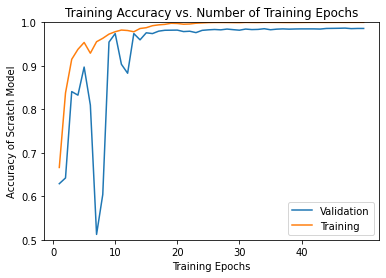

50


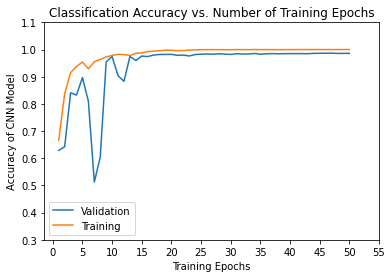

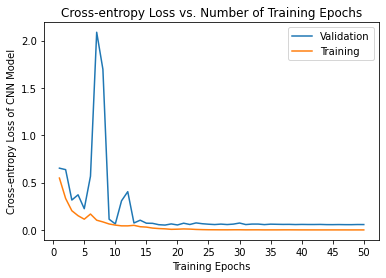

tensor([[2459.,   41.],
        [  25., 2475.]])
[2484. 2516.]
[[0.9836 0.0164]
 [0.01   0.99  ]]



Fold- 3 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                               | 0/50 [00:00<?, ?it/s]



----------
Epoch 0/49
LR 1e-05
[[5978. 1522.]
 [3362. 4138.]]
train: CE: 0.594466, MSE: 0.119484, loss: 0.546968
train Acc: 0.6744
train Bal. Acc: 0.6744


num_epochs:   2%|█▎                                                                  | 1/50 [06:28<5:17:24, 388.66s/it]

[[   0. 2500.]
 [   0. 2500.]]
val: CE: 1.497761, MSE: 0.110885, loss: 1.359073
val Acc: 0.5000
val Bal. Acc: 0.5000
saving best model
Total time: 0:06:28.667358
Epoch time: 6m 29s


----------
Epoch 1/49
LR 1e-05
[[6383. 1117.]
 [1294. 6206.]]
train: CE: 0.363831, MSE: 0.065573, loss: 0.334005
train Acc: 0.8393
train Bal. Acc: 0.8393


num_epochs:   4%|██▋                                                                 | 2/50 [12:57<5:10:54, 388.63s/it]

[[2459.   41.]
 [1487. 1013.]]
val: CE: 0.782268, MSE: 0.013174, loss: 0.705358
val Acc: 0.6944
val Bal. Acc: 0.6944
saving best model
Total time: 0:12:57.277158
Epoch time: 6m 29s


----------
Epoch 2/49
LR 1e-05
[[6677.  823.]
 [ 611. 6889.]]
train: CE: 0.237818, MSE: 0.008535, loss: 0.214890
train Acc: 0.9044
train Bal. Acc: 0.9044


num_epochs:   6%|████                                                                | 3/50 [19:26<5:04:28, 388.69s/it]

[[2483.   17.]
 [1368. 1132.]]
val: CE: 0.727999, MSE: 0.006904, loss: 0.655890
val Acc: 0.7230
val Bal. Acc: 0.7230
saving best model
Total time: 0:19:26.030097
Epoch time: 6m 29s


----------
Epoch 3/49
LR 1e-05
[[6955.  545.]
 [ 378. 7122.]]
train: CE: 0.171703, MSE: 0.005786, loss: 0.155112
train Acc: 0.9385
train Bal. Acc: 0.9385


num_epochs:   8%|█████▍                                                              | 4/50 [25:55<4:58:06, 388.84s/it]

[[2095.  405.]
 [  10. 2490.]]
val: CE: 0.199730, MSE: 0.004043, loss: 0.180161
val Acc: 0.9170
val Bal. Acc: 0.9170
saving best model
Total time: 0:25:55.103574
Epoch time: 6m 29s


----------
Epoch 4/49
LR 1e-05
[[7051.  449.]
 [ 209. 7291.]]
train: CE: 0.125876, MSE: 0.003596, loss: 0.113648
train Acc: 0.9561
train Bal. Acc: 0.9561


num_epochs:  10%|██████▊                                                             | 5/50 [32:23<4:51:35, 388.79s/it]

[[2372.  128.]
 [  40. 2460.]]
val: CE: 0.095973, MSE: 0.003093, loss: 0.086685
val Acc: 0.9664
val Bal. Acc: 0.9664
saving best model
Total time: 0:32:23.818552
Epoch time: 6m 29s


----------
Epoch 5/49
LR 5e-05
[[6845.  655.]
 [ 398. 7102.]]
train: CE: 0.187976, MSE: 0.003966, loss: 0.169575
train Acc: 0.9298
train Bal. Acc: 0.9298


num_epochs:  12%|████████▏                                                           | 6/50 [38:59<4:46:46, 391.05s/it]

[[2128.  372.]
 [   8. 2492.]]
val: CE: 0.185768, MSE: 0.003145, loss: 0.167506
val Acc: 0.9240
val Bal. Acc: 0.9240
Total time: 0:38:59.241014
Epoch time: 6m 35s


----------
Epoch 6/49
LR 5e-05
[[7106.  394.]
 [ 221. 7279.]]
train: CE: 0.110252, MSE: 0.002822, loss: 0.099509
train Acc: 0.9590
train Bal. Acc: 0.9590


num_epochs:  14%|█████████▌                                                          | 7/50 [45:27<4:39:42, 390.29s/it]

[[2469.   31.]
 [ 238. 2262.]]
val: CE: 0.168590, MSE: 0.001936, loss: 0.151925
val Acc: 0.9462
val Bal. Acc: 0.9462
Total time: 0:45:27.965395
Epoch time: 6m 29s


----------
Epoch 7/49
LR 5e-05
[[7161.  339.]
 [ 162. 7338.]]
train: CE: 0.085039, MSE: 0.001872, loss: 0.076723
train Acc: 0.9666
train Bal. Acc: 0.9666


num_epochs:  16%|██████████▉                                                         | 8/50 [51:56<4:32:51, 389.79s/it]

[[2245.  255.]
 [  23. 2477.]]
val: CE: 0.130908, MSE: 0.001465, loss: 0.117963
val Acc: 0.9444
val Bal. Acc: 0.9444
Total time: 0:51:56.701692
Epoch time: 6m 29s


----------
Epoch 8/49
LR 5e-05
[[7197.  303.]
 [ 177. 7323.]]
train: CE: 0.083608, MSE: 0.001469, loss: 0.075394
train Acc: 0.9680
train Bal. Acc: 0.9680


num_epochs:  18%|████████████▏                                                       | 9/50 [58:25<4:26:13, 389.60s/it]

[[2494.    6.]
 [ 965. 1535.]]
val: CE: 0.468774, MSE: 0.001208, loss: 0.422017
val Acc: 0.8058
val Bal. Acc: 0.8058
Total time: 0:58:25.877072
Epoch time: 6m 29s


----------
Epoch 9/49
LR 5e-05
[[7238.  262.]
 [ 155. 7345.]]
train: CE: 0.071692, MSE: 0.001304, loss: 0.064653
train Acc: 0.9722
train Bal. Acc: 0.9722


num_epochs:  20%|█████████████                                                    | 10/50 [1:04:55<4:19:38, 389.46s/it]

[[2306.  194.]
 [  16. 2484.]]
val: CE: 0.116575, MSE: 0.001190, loss: 0.105036
val Acc: 0.9580
val Bal. Acc: 0.9580
Total time: 1:04:55.030465
Epoch time: 6m 29s


----------
Epoch 10/49
LR 5e-05
[[7311.  189.]
 [  90. 7410.]]
train: CE: 0.049559, MSE: 0.001267, loss: 0.044730
train Acc: 0.9814
train Bal. Acc: 0.9814


num_epochs:  22%|██████████████▎                                                  | 11/50 [1:11:24<4:13:09, 389.47s/it]

[[2482.   18.]
 [ 255. 2245.]]
val: CE: 0.151621, MSE: 0.001058, loss: 0.136565
val Acc: 0.9454
val Bal. Acc: 0.9454
Total time: 1:11:24.521906
Epoch time: 6m 29s


----------
Epoch 11/49
LR 5e-05
[[7354.  146.]
 [  78. 7422.]]
train: CE: 0.040115, MSE: 0.001160, loss: 0.036220
train Acc: 0.9851
train Bal. Acc: 0.9851


num_epochs:  24%|███████████████▌                                                 | 12/50 [1:17:53<4:06:28, 389.18s/it]

[[2299.  201.]
 [   8. 2492.]]
val: CE: 0.125720, MSE: 0.000990, loss: 0.113247
val Acc: 0.9582
val Bal. Acc: 0.9582
Total time: 1:17:53.022500
Epoch time: 6m 29s


----------
Epoch 12/49
LR 5e-05
[[7359.  141.]
 [  89. 7411.]]
train: CE: 0.041009, MSE: 0.001098, loss: 0.037018
train Acc: 0.9847
train Bal. Acc: 0.9847


num_epochs:  26%|████████████████▉                                                | 13/50 [1:24:21<3:59:55, 389.07s/it]

[[1883.  617.]
 [   0. 2500.]]
val: CE: 0.369175, MSE: 0.000976, loss: 0.332355
val Acc: 0.8766
val Bal. Acc: 0.8766
Total time: 1:24:21.832946
Epoch time: 6m 29s


----------
Epoch 13/49
LR 5e-05
[[7372.  128.]
 [  70. 7430.]]
train: CE: 0.033749, MSE: 0.001056, loss: 0.030480
train Acc: 0.9868
train Bal. Acc: 0.9868


num_epochs:  28%|██████████████████▏                                              | 14/50 [1:30:50<3:53:18, 388.84s/it]

[[1.585e+03 9.150e+02]
 [1.000e+00 2.499e+03]]
val: CE: 0.593078, MSE: 0.000926, loss: 0.533863
val Acc: 0.8168
val Bal. Acc: 0.8168
Total time: 1:30:50.146574
Epoch time: 6m 28s


----------
Epoch 14/49
LR 5e-05
[[7386.  114.]
 [  60. 7440.]]
train: CE: 0.030162, MSE: 0.001036, loss: 0.027250
train Acc: 0.9884
train Bal. Acc: 0.9884


num_epochs:  30%|███████████████████▌                                             | 15/50 [1:37:18<3:46:46, 388.75s/it]

[[2500.    0.]
 [2190.  310.]]
val: CE: 4.740947, MSE: 0.000906, loss: 4.266943
val Acc: 0.5620
val Bal. Acc: 0.5620
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
Total time: 1:37:18.695324
Epoch time: 6m 29s


----------
Epoch 15/49
LR 2.5e-05
[[7449.   51.]
 [  37. 7463.]]
train: CE: 0.017595, MSE: 0.000997, loss: 0.015935
train Acc: 0.9941
train Bal. Acc: 0.9941


num_epochs:  32%|████████████████████▊                                            | 16/50 [1:43:46<3:40:11, 388.58s/it]

[[2410.   90.]
 [  12. 2488.]]
val: CE: 0.072944, MSE: 0.000889, loss: 0.065739
val Acc: 0.9796
val Bal. Acc: 0.9796
saving best model
Total time: 1:43:46.877900
Epoch time: 6m 28s


----------
Epoch 16/49
LR 2.5e-05
[[7463.   37.]
 [  20. 7480.]]
train: CE: 0.011364, MSE: 0.000988, loss: 0.010326
train Acc: 0.9962
train Bal. Acc: 0.9962


num_epochs:  34%|██████████████████████                                           | 17/50 [1:50:15<3:33:39, 388.46s/it]

[[2450.   50.]
 [  28. 2472.]]
val: CE: 0.063174, MSE: 0.000873, loss: 0.056944
val Acc: 0.9844
val Bal. Acc: 0.9844
saving best model
Total time: 1:50:15.074226
Epoch time: 6m 28s


----------
Epoch 17/49
LR 2.5e-05
[[7477.   23.]
 [  20. 7480.]]
train: CE: 0.009292, MSE: 0.000977, loss: 0.008461
train Acc: 0.9971
train Bal. Acc: 0.9971


num_epochs:  36%|███████████████████████▍                                         | 18/50 [1:56:43<3:27:10, 388.44s/it]

[[2377.  123.]
 [  10. 2490.]]
val: CE: 0.092412, MSE: 0.000870, loss: 0.083258
val Acc: 0.9734
val Bal. Acc: 0.9734
Total time: 1:56:43.461616
Epoch time: 6m 28s


----------
Epoch 18/49
LR 2.5e-05
[[7479.   21.]
 [   9. 7491.]]
train: CE: 0.006275, MSE: 0.000970, loss: 0.005745
train Acc: 0.9980
train Bal. Acc: 0.9980


num_epochs:  38%|████████████████████████▋                                        | 19/50 [2:03:11<3:20:39, 388.38s/it]

[[2456.   44.]
 [  49. 2451.]]
val: CE: 0.076706, MSE: 0.000859, loss: 0.069121
val Acc: 0.9814
val Bal. Acc: 0.9814
Total time: 2:03:11.697713
Epoch time: 6m 28s


----------
Epoch 19/49
LR 2.5e-05
[[7481.   19.]
 [  14. 7486.]]
train: CE: 0.007444, MSE: 0.000961, loss: 0.006796
train Acc: 0.9978
train Bal. Acc: 0.9978


num_epochs:  40%|██████████████████████████                                       | 20/50 [2:09:39<3:14:08, 388.28s/it]

[[2445.   55.]
 [  42. 2458.]]
val: CE: 0.080573, MSE: 0.000852, loss: 0.072601
val Acc: 0.9806
val Bal. Acc: 0.9806
Total time: 2:09:39.758299
Epoch time: 6m 28s


----------
Epoch 20/49
LR 2.5e-05
[[7483.   17.]
 [  13. 7487.]]
train: CE: 0.006973, MSE: 0.000957, loss: 0.006371
train Acc: 0.9980
train Bal. Acc: 0.9980


num_epochs:  42%|███████████████████████████▎                                     | 21/50 [2:16:08<3:07:41, 388.32s/it]

[[2489.   11.]
 [ 206. 2294.]]
val: CE: 0.182465, MSE: 0.000849, loss: 0.164303
val Acc: 0.9566
val Bal. Acc: 0.9566
Total time: 2:16:08.151500
Epoch time: 6m 28s


----------
Epoch 21/49
LR 2.5e-05
[[7.483e+03 1.700e+01]
 [7.000e+00 7.493e+03]]
train: CE: 0.005569, MSE: 0.000950, loss: 0.005107
train Acc: 0.9984
train Bal. Acc: 0.9984


num_epochs:  44%|████████████████████████████▌                                    | 22/50 [2:22:36<3:01:11, 388.27s/it]

[[2482.   18.]
 [ 205. 2295.]]
val: CE: 0.172086, MSE: 0.000838, loss: 0.154962
val Acc: 0.9554
val Bal. Acc: 0.9554
Epoch    17: reducing learning rate of group 0 to 1.2500e-05.
Total time: 2:22:36.326451
Epoch time: 6m 28s


----------
Epoch 22/49
LR 1.25e-05
[[7.492e+03 8.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.002881, MSE: 0.000939, loss: 0.002687
train Acc: 0.9993
train Bal. Acc: 0.9993


num_epochs:  46%|█████████████████████████████▉                                   | 23/50 [2:29:04<2:54:42, 388.24s/it]

[[2459.   41.]
 [  33. 2467.]]
val: CE: 0.065461, MSE: 0.000832, loss: 0.058998
val Acc: 0.9852
val Bal. Acc: 0.9852
saving best model
Total time: 2:29:04.480056
Epoch time: 6m 28s


----------
Epoch 23/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001597, MSE: 0.000935, loss: 0.001531
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  48%|███████████████████████████████▏                                 | 24/50 [2:35:32<2:48:13, 388.22s/it]

[[2463.   37.]
 [  55. 2445.]]
val: CE: 0.073125, MSE: 0.000829, loss: 0.065895
val Acc: 0.9816
val Bal. Acc: 0.9816
Total time: 2:35:32.664629
Epoch time: 6m 28s


----------
Epoch 24/49
LR 1.25e-05
[[7.499e+03 1.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001375, MSE: 0.000931, loss: 0.001331
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  50%|████████████████████████████████▌                                | 25/50 [2:42:00<2:41:41, 388.08s/it]

[[2475.   25.]
 [  77. 2423.]]
val: CE: 0.083302, MSE: 0.000825, loss: 0.075055
val Acc: 0.9796
val Bal. Acc: 0.9796
Total time: 2:42:00.397683
Epoch time: 6m 28s


----------
Epoch 25/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [4.000e+00 7.496e+03]]
train: CE: 0.001810, MSE: 0.000927, loss: 0.001722
train Acc: 0.9996
train Bal. Acc: 0.9996


num_epochs:  52%|█████████████████████████████████▊                               | 26/50 [2:48:28<2:35:15, 388.15s/it]

[[2446.   54.]
 [  27. 2473.]]
val: CE: 0.071209, MSE: 0.000821, loss: 0.064170
val Acc: 0.9838
val Bal. Acc: 0.9838
Total time: 2:48:28.710699
Epoch time: 6m 28s


----------
Epoch 26/49
LR 1.25e-05
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000928, MSE: 0.000923, loss: 0.000927
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  54%|███████████████████████████████████                              | 27/50 [2:54:56<2:28:45, 388.07s/it]

[[2453.   47.]
 [  25. 2475.]]
val: CE: 0.065412, MSE: 0.000817, loss: 0.058953
val Acc: 0.9856
val Bal. Acc: 0.9856
saving best model
Total time: 2:54:56.615053
Epoch time: 6m 28s


----------
Epoch 27/49
LR 1.25e-05
[[7.493e+03 7.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.001911, MSE: 0.000919, loss: 0.001812
train Acc: 0.9993
train Bal. Acc: 0.9993


num_epochs:  56%|████████████████████████████████████▍                            | 28/50 [3:01:24<2:22:19, 388.14s/it]

[[2467.   33.]
 [  53. 2447.]]
val: CE: 0.077449, MSE: 0.000813, loss: 0.069786
val Acc: 0.9828
val Bal. Acc: 0.9828
Total time: 3:01:24.910454
Epoch time: 6m 28s


----------
Epoch 28/49
LR 1.25e-05
[[7.499e+03 1.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.001147, MSE: 0.000914, loss: 0.001123
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  58%|█████████████████████████████████████▋                           | 29/50 [3:07:53<2:15:54, 388.31s/it]

[[2473.   27.]
 [  57. 2443.]]
val: CE: 0.077138, MSE: 0.000807, loss: 0.069505
val Acc: 0.9832
val Bal. Acc: 0.9832
Epoch    24: reducing learning rate of group 0 to 6.2500e-06.
Total time: 3:07:53.606086
Epoch time: 6m 29s


----------
Epoch 29/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000828, MSE: 0.000910, loss: 0.000836
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  60%|███████████████████████████████████████                          | 30/50 [3:14:21<2:09:23, 388.16s/it]

[[2477.   23.]
 [  76. 2424.]]
val: CE: 0.086719, MSE: 0.000805, loss: 0.078128
val Acc: 0.9802
val Bal. Acc: 0.9802
Total time: 3:14:21.435758
Epoch time: 6m 28s


----------
Epoch 30/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000757, MSE: 0.000908, loss: 0.000772
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  62%|████████████████████████████████████████▎                        | 31/50 [3:20:50<2:02:59, 388.41s/it]

[[2463.   37.]
 [  33. 2467.]]
val: CE: 0.064745, MSE: 0.000803, loss: 0.058351
val Acc: 0.9860
val Bal. Acc: 0.9860
saving best model
Total time: 3:20:50.435210
Epoch time: 6m 29s


----------
Epoch 31/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000819, MSE: 0.000906, loss: 0.000827
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  64%|█████████████████████████████████████████▌                       | 32/50 [3:27:19<1:56:32, 388.49s/it]

[[2465.   35.]
 [  44. 2456.]]
val: CE: 0.068548, MSE: 0.000801, loss: 0.061774
val Acc: 0.9842
val Bal. Acc: 0.9842
Total time: 3:27:19.107978
Epoch time: 6m 29s


----------
Epoch 32/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000638, MSE: 0.000903, loss: 0.000664
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  66%|██████████████████████████████████████████▉                      | 33/50 [3:33:47<1:50:02, 388.39s/it]

[[2470.   30.]
 [  61. 2439.]]
val: CE: 0.074141, MSE: 0.000799, loss: 0.066807
val Acc: 0.9818
val Bal. Acc: 0.9818
Total time: 3:33:47.267132
Epoch time: 6m 28s


----------
Epoch 33/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000446, MSE: 0.000901, loss: 0.000491
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  68%|████████████████████████████████████████████▏                    | 34/50 [3:40:15<1:43:35, 388.44s/it]

[[2468.   32.]
 [  57. 2443.]]
val: CE: 0.070363, MSE: 0.000796, loss: 0.063407
val Acc: 0.9822
val Bal. Acc: 0.9822
Total time: 3:40:15.822190
Epoch time: 6m 29s


----------
Epoch 34/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000422, MSE: 0.000899, loss: 0.000469
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  70%|█████████████████████████████████████████████▌                   | 35/50 [3:46:44<1:37:06, 388.43s/it]

[[2465.   35.]
 [  38. 2462.]]
val: CE: 0.067500, MSE: 0.000794, loss: 0.060829
val Acc: 0.9854
val Bal. Acc: 0.9854
Total time: 3:46:44.218327
Epoch time: 6m 28s


----------
Epoch 35/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000808, MSE: 0.000897, loss: 0.000817
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  72%|██████████████████████████████████████████████▊                  | 36/50 [3:53:12<1:30:35, 388.28s/it]

[[2466.   34.]
 [  39. 2461.]]
val: CE: 0.068024, MSE: 0.000792, loss: 0.061301
val Acc: 0.9854
val Bal. Acc: 0.9854
Epoch    31: reducing learning rate of group 0 to 3.1250e-06.
Total time: 3:53:12.159406
Epoch time: 6m 28s


----------
Epoch 36/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000539, MSE: 0.000895, loss: 0.000575
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  74%|████████████████████████████████████████████████                 | 37/50 [3:59:40<1:24:08, 388.35s/it]

[[2467.   33.]
 [  40. 2460.]]
val: CE: 0.067916, MSE: 0.000791, loss: 0.061203
val Acc: 0.9854
val Bal. Acc: 0.9854
Total time: 3:59:40.683204
Epoch time: 6m 29s


----------
Epoch 37/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000471, MSE: 0.000894, loss: 0.000514
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  76%|█████████████████████████████████████████████████▍               | 38/50 [4:06:08<1:17:37, 388.09s/it]

[[2469.   31.]
 [  53. 2447.]]
val: CE: 0.069814, MSE: 0.000790, loss: 0.062912
val Acc: 0.9832
val Bal. Acc: 0.9832
Total time: 4:06:08.143932
Epoch time: 6m 27s


----------
Epoch 38/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000382, MSE: 0.000893, loss: 0.000433
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  78%|██████████████████████████████████████████████████▋              | 39/50 [4:12:36<1:11:10, 388.18s/it]

[[2466.   34.]
 [  40. 2460.]]
val: CE: 0.067570, MSE: 0.000789, loss: 0.060892
val Acc: 0.9852
val Bal. Acc: 0.9852
Total time: 4:12:36.553880
Epoch time: 6m 28s


----------
Epoch 39/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000494, MSE: 0.000892, loss: 0.000534
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  80%|████████████████████████████████████████████████████             | 40/50 [4:19:04<1:04:41, 388.20s/it]

[[2468.   32.]
 [  40. 2460.]]
val: CE: 0.066554, MSE: 0.000789, loss: 0.059977
val Acc: 0.9856
val Bal. Acc: 0.9856
Total time: 4:19:04.777535
Epoch time: 6m 28s


----------
Epoch 40/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000366, MSE: 0.000891, loss: 0.000419
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  82%|██████████████████████████████████████████████████████▉            | 41/50 [4:25:32<58:13, 388.20s/it]

[[2473.   27.]
 [  58. 2442.]]
val: CE: 0.069830, MSE: 0.000788, loss: 0.062926
val Acc: 0.9830
val Bal. Acc: 0.9830
Total time: 4:25:32.990668
Epoch time: 6m 28s


----------
Epoch 41/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000347, MSE: 0.000890, loss: 0.000402
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  84%|████████████████████████████████████████████████████████▎          | 42/50 [4:32:01<51:45, 388.21s/it]

[[2467.   33.]
 [  44. 2456.]]
val: CE: 0.068180, MSE: 0.000787, loss: 0.061440
val Acc: 0.9846
val Bal. Acc: 0.9846
Total time: 4:32:01.217357
Epoch time: 6m 28s


----------
Epoch 42/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000313, MSE: 0.000889, loss: 0.000370
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  86%|█████████████████████████████████████████████████████████▌         | 43/50 [4:38:29<45:17, 388.15s/it]

[[2469.   31.]
 [  49. 2451.]]
val: CE: 0.069306, MSE: 0.000786, loss: 0.062454
val Acc: 0.9840
val Bal. Acc: 0.9840
Epoch    38: reducing learning rate of group 0 to 1.5625e-06.
Total time: 4:38:29.245306
Epoch time: 6m 28s


----------
Epoch 43/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000422, MSE: 0.000889, loss: 0.000469
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  88%|██████████████████████████████████████████████████████████▉        | 44/50 [4:44:56<38:48, 388.01s/it]

[[2469.   31.]
 [  50. 2450.]]
val: CE: 0.069315, MSE: 0.000785, loss: 0.062462
val Acc: 0.9838
val Bal. Acc: 0.9838
Total time: 4:44:56.913634
Epoch time: 6m 28s


----------
Epoch 44/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000348, MSE: 0.000888, loss: 0.000402
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  90%|████████████████████████████████████████████████████████████▎      | 45/50 [4:51:24<32:20, 388.00s/it]

[[2473.   27.]
 [  61. 2439.]]
val: CE: 0.072597, MSE: 0.000785, loss: 0.065416
val Acc: 0.9824
val Bal. Acc: 0.9824
Total time: 4:51:24.905570
Epoch time: 6m 28s


----------
Epoch 45/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000317, MSE: 0.000888, loss: 0.000374
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [4:57:52<25:51, 387.91s/it]

[[2467.   33.]
 [  41. 2459.]]
val: CE: 0.068226, MSE: 0.000784, loss: 0.061482
val Acc: 0.9852
val Bal. Acc: 0.9852
Total time: 4:57:52.581459
Epoch time: 6m 28s


----------
Epoch 46/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000401, MSE: 0.000887, loss: 0.000450
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [5:04:20<19:24, 388.06s/it]

[[2473.   27.]
 [  55. 2445.]]
val: CE: 0.071072, MSE: 0.000784, loss: 0.064043
val Acc: 0.9836
val Bal. Acc: 0.9836
Total time: 5:04:20.997841
Epoch time: 6m 28s


----------
Epoch 47/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000389, MSE: 0.000887, loss: 0.000439
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [5:10:48<12:55, 387.97s/it]

[[2463.   37.]
 [  35. 2465.]]
val: CE: 0.065495, MSE: 0.000783, loss: 0.059024
val Acc: 0.9856
val Bal. Acc: 0.9856
Total time: 5:10:48.767319
Epoch time: 6m 28s


----------
Epoch 48/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000350, MSE: 0.000886, loss: 0.000404
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [5:17:16<06:27, 387.94s/it]

[[2474.   26.]
 [  58. 2442.]]
val: CE: 0.073541, MSE: 0.000783, loss: 0.066266
val Acc: 0.9832
val Bal. Acc: 0.9832
Total time: 5:17:16.644565
Epoch time: 6m 28s


----------
Epoch 49/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000230, MSE: 0.000886, loss: 0.000295
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs: 100%|███████████████████████████████████████████████████████████████████| 50/50 [5:23:44<00:00, 388.50s/it]

[[2472.   28.]
 [  51. 2449.]]
val: CE: 0.070235, MSE: 0.000782, loss: 0.063290
val Acc: 0.9842
val Bal. Acc: 0.9842
Epoch    45: reducing learning rate of group 0 to 7.8125e-07.
Total time: 5:23:44.954949
Epoch time: 6m 28s
Best val loss: 0.058351
Best val acc: 0.986000
50


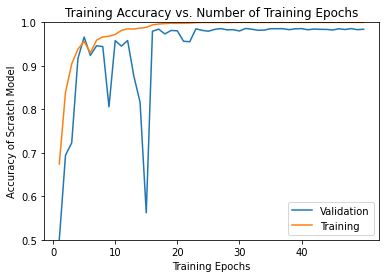

50


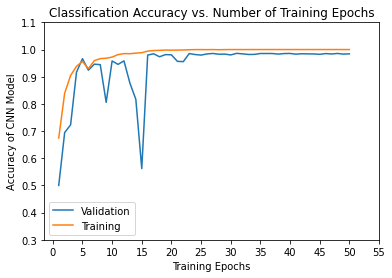

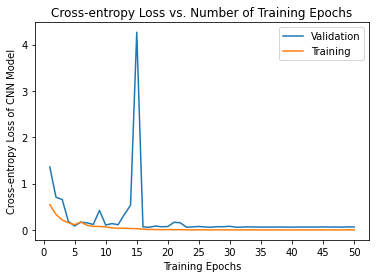

tensor([[2463.,   37.],
        [  33., 2467.]])
[2496. 2504.]
[[0.9852 0.0148]
 [0.0132 0.9868]]





In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,4):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
#     trainpath =[X[i] for i in trainindex[runs]]
#     testpath =[X[i] for i in testindex[runs]]
    
    trainpath2d =[X2d[i] for i in trainindex2d[runs]]
    trainpath3d =[X3d[i] for i in trainindex3d[runs]]
    testpath2d =[X2d[i] for i in testindex2d[runs]]
    testpath3d =[X3d[i] for i in testindex3d[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath2d,trainpath3d)
    image_datasets['val'] = MyDataset(testpath2d,testpath3d)
    
#     ImgIdx = 4
#     [ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(ImgIdx)
#     image2d = np.transpose(ImgTensor2d.numpy(), (1,2,0))
#     image3d = np.transpose(np.squeeze(ImgTensor3d.numpy()), (1,2,0))
#     DisplayImage(image2d,image2d.min(),image3d.max(),ImgIdx)
#     DisplayImage(image3d,image3d.min(),image3d.max(),ImgIdx)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 2
    in_channel = 1
    num_epochs = 50
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet2D3D(num_class, in_channel)
        model.apply(init_weights)
#         model.half() 
        model
        model = model.to(device)
#         model = model.half()
        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.99, 0.9999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(),lr=5e-5,betas = (0.99, 0.9999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=4, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=4, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    shistVal = [h.cpu().numpy() for h in scratch_hist_val]
    shistTrain= [h.cpu().numpy() for h in scratch_hist_train]
    # shistBaccTrain= [h.cpu().numpy() for h in train_Bacc_hist]
    # shistBaccVal= [h.cpu().numpy() for h in val_Bacc_hist]
    # shistLossTrain= [h.cpu().numpy() for h in loss_hist_train]
    # shistLossVal= [h.cpu().numpy() for h in loss_hist_val]
    # shistLR= [h.cpu().numpy() for h in lr_hist]
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,shistTrain, delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,shistVal , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist, delimiter=",")

    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs2d, inputs3d, classes) in enumerate(dataloaders_dict['val']):
            inputs2d = inputs2d.type(torch.FloatTensor)
            inputs2d = inputs2d.to(device)
            inputs3d = inputs3d.type(torch.FloatTensor)
            inputs3d = inputs3d.to(device)
            classes = classes.to(device)
            _,_, outputs = model(inputs2d, inputs3d)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(2,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "UNet_LiverStellate_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "UNet_LiverStellate_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'UNet_LiverStellate_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
runs = 1
shistVal = [h.cpu().numpy() for h in scratch_hist_val]
shistTrain= [h.cpu().numpy() for h in scratch_hist_train]
# shistBaccTrain= [h.cpu().numpy() for h in train_Bacc_hist]
# shistBaccVal= [h.cpu().numpy() for h in val_Bacc_hist]
# shistLossTrain= [h.cpu().numpy() for h in loss_hist_train]
# shistLossVal= [h.cpu().numpy() for h in loss_hist_val]
# shistLR= [h.cpu().numpy() for h in lr_hist]
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,shistTrain, delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,shistVal , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist, delimiter=",")

shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs2d, inputs3d, classes) in enumerate(dataloaders_dict['val']):
        inputs2d = inputs2d.type(torch.FloatTensor)
        inputs2d = inputs2d.to(device)
        inputs3d = inputs3d.type(torch.FloatTensor)
        inputs3d = inputs3d.to(device)
        classes = classes.to(device)
        _,_, outputs = model(inputs2d, inputs3d)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(2,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "UNet_LiverStellate_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "UNet_LiverStellate_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'UNet_LiverStellate_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)

In [19]:
import pandas as pd

df = pd.read_csv (r'./UNet_LiverStellate_confusionPer_0.csv',header=None)
ConfuMat0 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverStellate_confusionPer_1.csv',header=None)
ConfuMat1 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverStellate_confusionPer_2.csv',header=None)
ConfuMat2 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverStellate_confusionPer_3.csv',header=None)
ConfuMat3 = df.to_numpy()

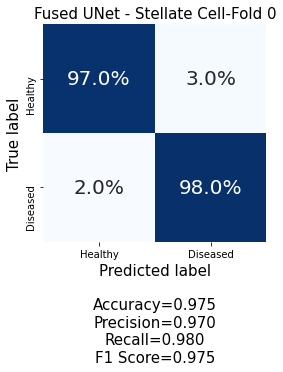

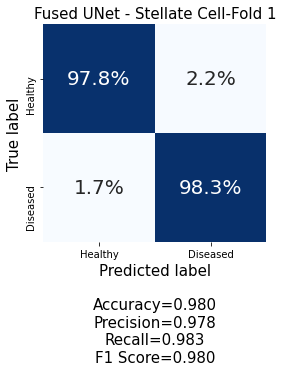

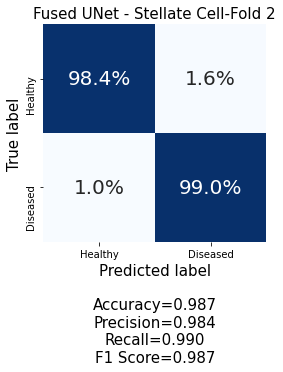

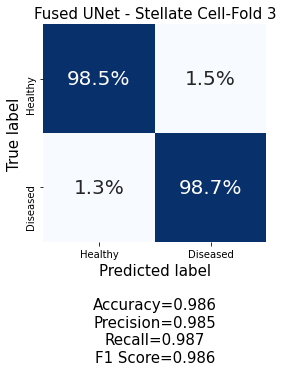

In [30]:
GroupName = ['Healthy','Diseased']
categories = GroupName
make_confusion_matrix(ConfuMat0, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Stellate Cell-Fold 0')
make_confusion_matrix(ConfuMat1, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Stellate Cell-Fold 1')
make_confusion_matrix(ConfuMat2, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Stellate Cell-Fold 2')
make_confusion_matrix(ConfuMat3, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Stellate Cell-Fold 3')

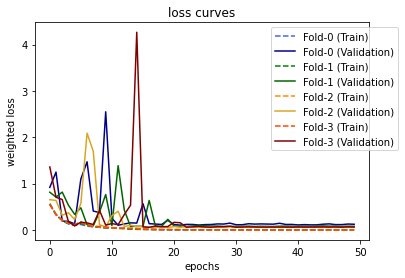

In [24]:
import pandas as pd

df = pd.read_csv (r'./training_loss_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'./training_loss_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'./training_loss_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'./training_loss_3.csv',header=None)
TrainLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/training_loss_4.csv',header=None)
# TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'./validation_loss_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_3.csv',header=None)
ValLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/validation_loss_4.csv',header=None)
# ValLoss4 = df.to_numpy()

plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
# plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
# plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

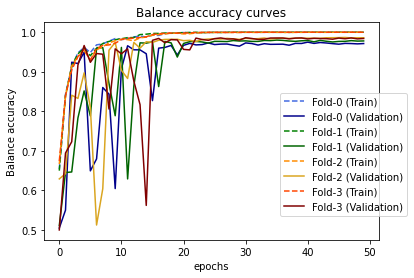

In [36]:
import pandas as pd

df = pd.read_csv (r'./training_Bacc_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_3.csv',header=None)
TrainLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/training_loss_4.csv',header=None)
# TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'./validation_Bacc_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_3.csv',header=None)
ValLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/validation_loss_4.csv',header=None)
# ValLoss4 = df.to_numpy()

plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
# plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
# plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('Balance accuracy curves')
plt.xlabel('epochs')
plt.ylabel('Balance accuracy')
plt.legend(bbox_to_anchor=(1.1, 0.7))
plt.show()

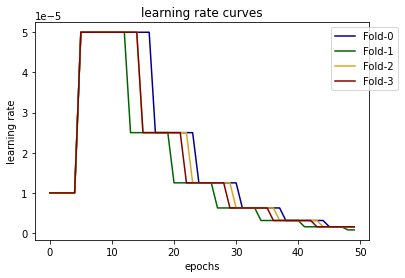

In [26]:
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_1.csv',header=None)
LearnRate1 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_2.csv',header=None)
LearnRate2 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_3.csv',header=None)
LearnRate3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/learning_rate_4.csv',header=None)
# LearnRate4 = df.to_numpy()

plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.plot(LearnRate1,label = 'Fold-1', color='darkgreen', linestyle = '-')
plt.plot(LearnRate2,label = 'Fold-2', color='goldenrod', linestyle = '-')
plt.plot(LearnRate3,label = 'Fold-3', color='maroon', linestyle = '-')
# plt.plot(LearnRate4,label = 'Fold-4', color='purple', linestyle = '-')
plt.title('learning rate curves')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [ ]:
type(scratch_hist_train)

In [29]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, annot_kws={"size": 20})

    if xyplotlabels:
        plt.ylabel('True label',fontsize = 15)
        plt.xlabel('Predicted label' + stats_text,fontsize = 15)
    else:
        plt.xlabel(stats_text,fontsize = 15)
    
    if title:
        plt.title(title,fontsize = 15)

In [ ]:
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',title = '3DCNN UNet - 3D Input')

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [ ]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-4]))
# scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
# list(scratch_model.children())

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(valpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, learning_rate=200,early_exaggeration = 50, n_iter=2000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK-293','HeLa','MCF-7']


In [ ]:
target_ids = range(len(outputlist))
plt.figure()
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

In [ ]:
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model = scratch_model.to(device)
scratch_model.eval()

In [ ]:
CellName = ['Granulocyte','Lymphocyte','Monocyte']
ImgTensor, Label = image_datasets['val'].__getitem__(2)
image = np.squeeze(ImgTensor.numpy())
print('Ground Truth Cell Type: ', CellName[Label])
DisplayImage(image,image.min(),image.max())

In [ ]:
inputs = torch.unsqueeze(ImgTensor,0).to(device)
[output,prediction] = scratch_model(inputs)
# output = output.squeeze()
output = output.squeeze()
output = output.cpu().clone().detach().numpy()
_, preds = torch.max(prediction, 1)
preds = preds.cpu().clone().detach()

In [ ]:
# print(output/output.max())
print(output.max())
print(output.shape)
print('Predicted Cell Type: ', CellName[preds])
image = np.squeeze(output)
DisplayImage(image,image.min(),image.max())